# 3DXRD indexing notebook - Grid indexing method  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# desination of H5 files
# replace below with e.g.:
# dset_path = '/data/visitor/expt1234/20240101/PROCESSED_DATA/sample/dataset/sample_dataset.h5'

dset_path = ''

phase_str = 'Fe'

# path to parameters .json/.par
parfile = ''

# peak filtration options
cf_strong_frac = 0.999
cf_strong_dsmax = 1.017
cf_strong_dstol = 0.025

# indexing options
rings_to_use = [0, 1, 3]

# makemap options
symmetry = "cubic"
makemap_tol_seq = [0.02, 0.015, 0.01]

gridpars = {
        'DSTOL' : 0.004,
        'RING1'  : [1,0,],
        'RING2' : [0,],
        'NUL' : True,
        'FITPOS' : True,
        'tolangle' : 0.50,
        'toldist' : 100.,
        'NTHREAD' : 1 ,
}

grid_xlim = 600  # um - extent away from rotation axis to search for grains
grid_ylim = 600
grid_zlim = 200
grid_step = 100  # step size of search grid, um

# fraction of expected number of peaks to accept in Makemap output
frac = 0.85

# find the spike
absolute_minpks = 56

dset_prefix = 'ff'

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
phase_str = "Fe"
parfile = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/pars_tdxrd.json"
cf_strong_frac = 0.9837
cf_strong_dsmax = 1.01
cf_strong_dstol = 0.01
rings_to_use = [0, 1, 3]
symmetry = "cubic"
makemap_tol_seq = [0.02, 0.015, 0.01]
gridpars = {
    "DSTOL": 0.004,
    "RING1": [1, 0],
    "RING2": [0],
    "NUL": True,
    "FITPOS": True,
    "tolangle": 0.5,
    "toldist": 100.0,
    "NTHREAD": 1,
}
grid_xlim = 600
grid_ylim = 600
grid_zlim = 200
grid_step = 100
frac = 0.85
absolute_minpks = 56
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/grid/FeAu_0p5_tR/FeAu_0p5_tR_ff1/FeAu_0p5_tR_ff1_dataset.h5"


In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt

import random
import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import dataset
from ImageD11.peakselect import select_ring_peaks_by_intensity
from ImageD11.nbGui import nb_utils as utils
from ImageD11.grid_index_parallel import grid_index_parallel

%matplotlib widget

# Load data
## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/RAW_DATA/"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/grid"
sample = "FeAu_0p5_tR"
dset = "ff1"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1


## Parameters
Specify the path to your parameter file

In [6]:
ds.parfile = parfile
ds.save()

## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229}

In [8]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


## Peaks

In [9]:
cf_3d = ds.get_cf_3d_from_disk()
ds.update_colfile_pars(cf_3d, phase_name=phase_str) 
cf_3d_path = 'cf_3d.flt'
cf_3d.writefile(cf_3d_path)

Reading your columnfile in hdf format


# Visualise data
### $d^{*}$ vs $\eta$

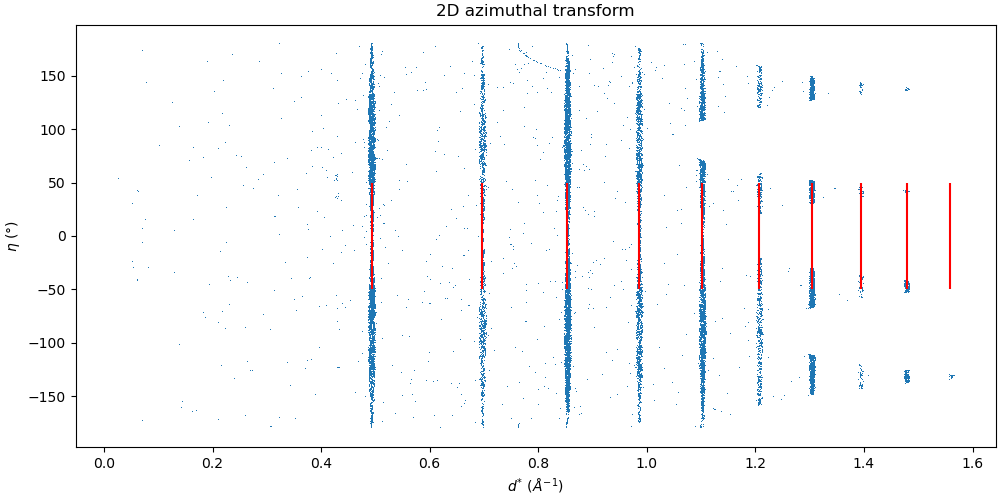

In [10]:
skip = 1  # we can skip peaks to speed up plotting if needed
ucell.makerings(cf_3d.ds.max())
fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(cf_3d.ds[::skip], cf_3d.eta[::skip], ',')
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', title='2D azimuthal transform')
plt.show()

# Filtration
Here we are filtering our peaks (`cf_3d`) to select only the strongest ones for indexing purposes only!  
We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  
`dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`dsmax`: The maximum allowed peak $d^{*}$ value. Used to limit the number of rings given to the indexer - 6-8 rings max are normally sufficient.   
`frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

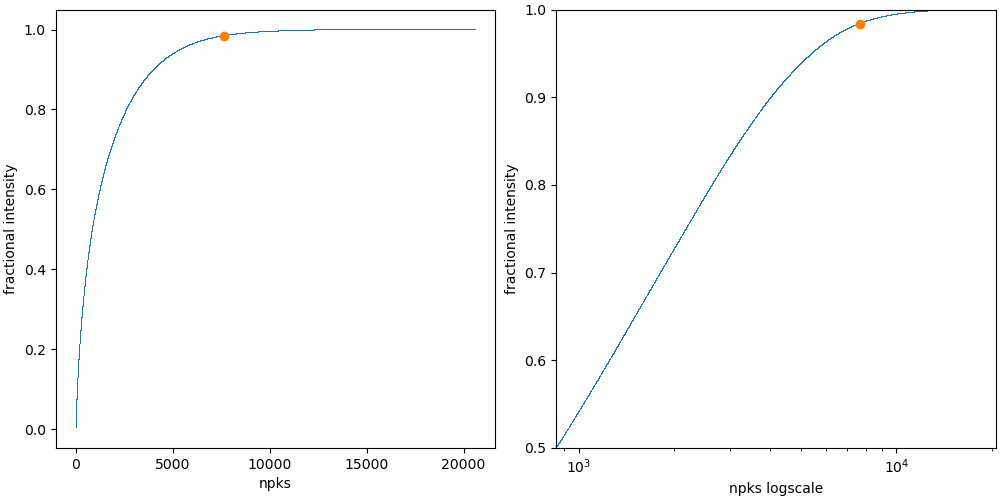

Filtered 7662 peaks from 31682


In [11]:
cf_strong = select_ring_peaks_by_intensity(cf_3d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)

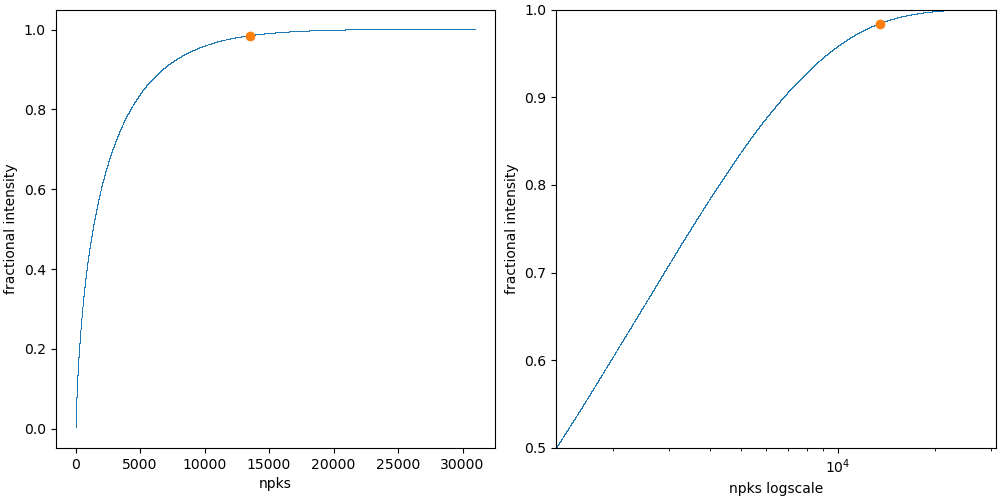

Filtered 13540 peaks from 31682


In [12]:
# we will also export some additional strong peaks across all rings
# this will be useful for grain refinement later (using makemap)
cf_strong_allrings = select_ring_peaks_by_intensity(cf_3d, frac=cf_strong_frac, dsmax=cf_3d.ds.max(), dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)
cf_strong_allrings_path = 'cf_strong_allrings.flt'
cf_strong_allrings.writefile(cf_strong_allrings_path)

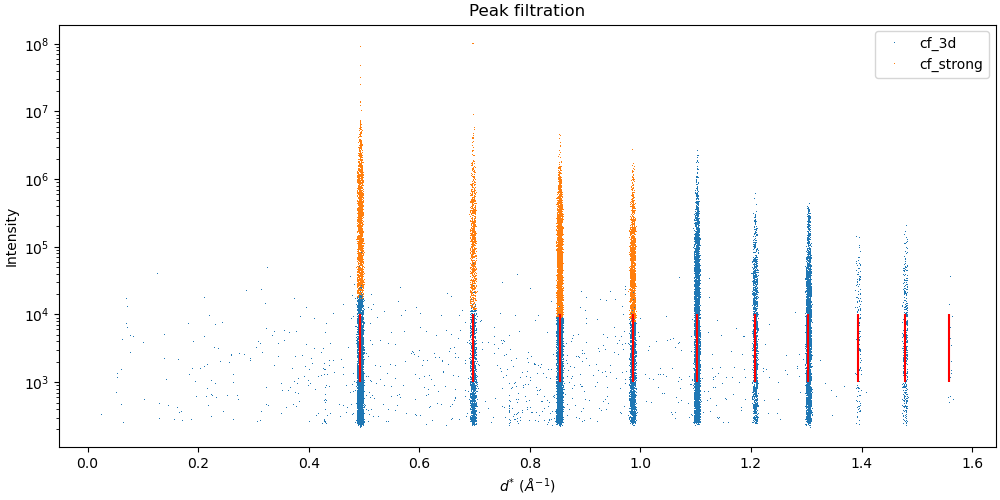

In [13]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_3d.ds[::skip], cf_3d.sum_intensity[::skip],',', label='cf_3d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
## Ring assignment

In [14]:
indexer = ImageD11.indexing.indexer_from_colfile_and_ucell(cf_strong, ucell)
indexer.ds_tol = cf_strong_dstol
ImageD11.indexing.loglevel = 1
indexer.assigntorings()
ImageD11.indexing.loglevel = 3
print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.09866116  0.21772692 -0.81879515]
 [-0.03152412  0.04888338 -0.48747349]
 [-0.09867997  0.72385197 -0.43635119]
 ...
 [-0.05254491 -0.42837134  0.23866334]
 [-0.09029043 -0.67091598  0.14185135]
 [-0.11627422  0.95488202 -0.23424652]] (7662, 3) float64
info: Assign to rings, maximum d-spacing considered: 0.991802
info: Ring assignment array shape (7662,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 3   ( -2, -2,  0)   12   1492       0     1492    61     24  16.13
info: Ring 2   ( -1, -1, -2)   24   3280       0     3280    68     48  13.95
info: Ring 1   (  0,  0, -2)    6    898       0      898    74     12  11.38
info: Ring 0   (  0, -1, -1)   12   1992       0     1992    82     24  8.04
info: 
min_pks:  - Current  -->  10
info:           - Expected --> 108

info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (7662, 3)
Indexing 7662 peaks


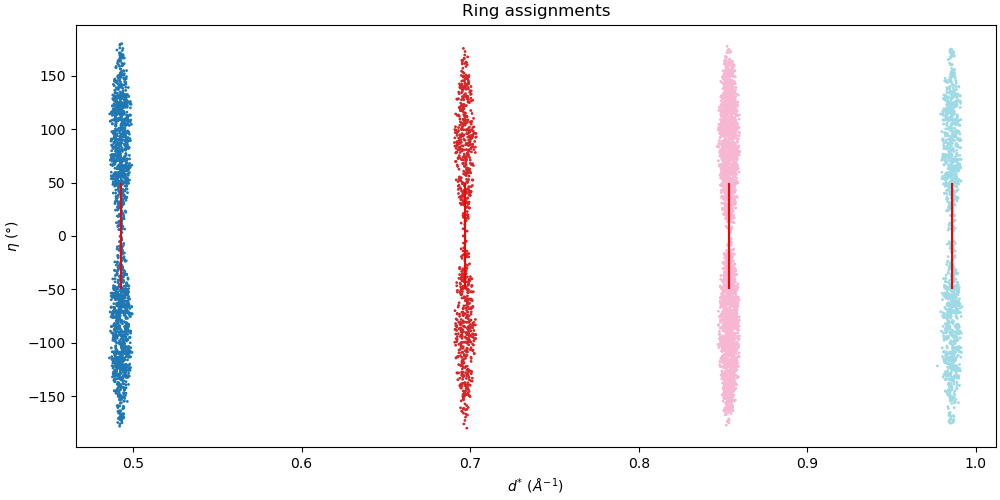

In [15]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
ax.scatter(indexer.colfile.ds[::skip], indexer.colfile.eta[::skip], c=indexer.ra[::skip]%20, cmap='tab20', s=1)
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', xlim=(min(ucell.ringds[0], cf_strong.ds.min()) - 0.02, cf_strong.ds.max() + 0.02), title='Ring assignments')
plt.show()

Now we need to compute the number of expected peaks.  
To do this, you add up the multiplicites of the rings you chose.  
If you recorded a 360 degree scan, multiply the result by 2.  
e.g given this output:
```
# info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
# info: Ring 3   ( -2, -2,  0)   12   2251       0     2251    93     24  16.11
# info: Ring 2   ( -1, -1, -2)   24   4899       0     4899   101     48  13.94
# info: Ring 1   ( -2,  0,  0)    6   1233       0     1233   102     12  11.37
# info: Ring 0   ( -1, -1,  0)   12   2861       0     2861   118     24  8.03
```
Selecting rings `[0,1,3]` we would get `(12+6+12)*2 = 84` peaks

In [16]:
peaks_expected = (12+6+12)*2

# choose the fraction of the number of peaks expected - this should be around 0.9 if you had a good clean segementation
# if you suspect you are missing peaks in your data, decrease to around 0.6

minpeaks = int(np.round(peaks_expected * frac, 2))
minpeaks

51

## Choose rings to export for grid index

In [17]:
mask = np.zeros(cf_strong.nrows, dtype=bool)
for ring in rings_to_use:
    mask |= indexer.ra == ring
peaks_to_export = cf_strong.copy()
peaks_to_export.filter(mask)

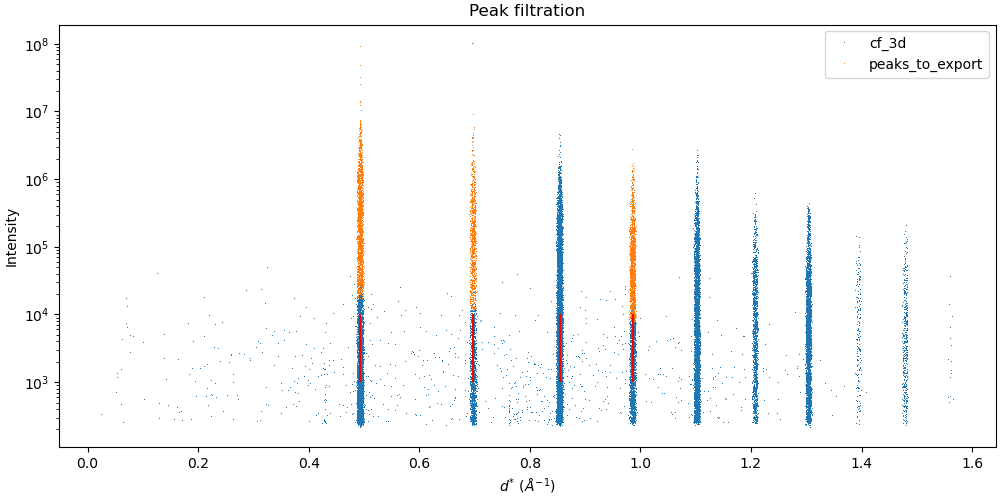

In [18]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_3d.ds[::skip], cf_3d.sum_intensity[::skip],',', label='cf_3d')
ax.plot(peaks_to_export.ds[::skip], peaks_to_export.sum_intensity[::skip],',', label='peaks_to_export')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

## Grid index

In [19]:
grid_peaks_path = 'grid_peaks.flt'
new_grid_peaks_path = 'grid_peaks.flt.new'
peaks_to_export.writefile(grid_peaks_path)  # export peaks
oldparfile = phase_str + '.par'
ds.phases.to_old_pars_file(oldparfile, phase_str)  # export parameter file
nproc = len(os.sched_getaffinity(os.getpid())) - 3

omega_slop = ds.ostep/2
gridpars['COSTOL'] = np.cos(np.radians(90 - ds.ostep))
gridpars['NPROC'] = nproc
gridpars['NPKS'] = minpeaks
gridpars['OMEGAFLOAT'] = omega_slop
gridpars['TOLSEQ'] = makemap_tol_seq
gridpars['SYMMETRY'] = symmetry

translations = [(t_x, t_y, t_z) # grid to search
    for t_x in range(-grid_xlim, grid_xlim+1, grid_step)
    for t_y in range(-grid_ylim, grid_ylim+1, grid_step) 
    for t_z in range(-grid_zlim, grid_zlim+1, grid_step) ]

random.seed(42) # reproducible
random.shuffle(translations)
tmp_output_path = 'tmp'
map_path = 'alltmp.map'
new_map_path = f'alltmp.map.new'
grid_index_parallel(grid_peaks_path, oldparfile, tmp_output_path, gridpars, translations)

Done init


Using a pool of 37 processes


           0.00% Position -400 -600 0 grains found 0 kept 0
           0.00% Position 400 500 -200 grains found 0 kept 0
           0.00% Position 300 600 -100 grains found 0 kept 0
           0.00% Position 600 -300 0 grains found 0 kept 0
           4.35% Position -500 200 -200 grains found 0 kept 0
           0.00% Position 200 600 -100 grains found 0 kept 0
           0.00% Position 500 -400 -200 grains found 0 kept 0
           0.00% Position 600 -200 0 grains found 0 kept 0
           0.00% Position -400 -200 -200 grains found 0 kept 0
           0.00% Position 500 -100 100 grains found 0 kept 0
           4.35% Position -600 100 -100 grains found 0 kept 0
           0.00% Position 300 -400 -200 grains found 0 kept 0
           0.00% Position -100 -500 100 grains found 0 kept 0
           4.35% Position -600 300 200 grains found 0 kept 0
           4.35% Position 600 400 100 grains found 0 kept 0
           0.00% Position 400 0 -200 grains found 0 kept 0
           0.00% Position

           8.70% Position -400 600 -100 grains found 0 kept 0
           4.55% Position 500 0 200 grains found 0 kept 0
          13.04% Position -600 -400 -200 grains found 0 kept 0
           8.70% Position -500 -500 200 grains found 0 kept 0
           4.35% Position 200 -400 -200 grains found 0 kept 0
           4.35% Position 100 400 200 grains found 0 kept 0
          13.04% Position -200 -600 200 grains found 0 kept 0
           4.35% Position 500 300 0 grains found 0 kept 0
          17.39% Position 400 500 -100 grains found 0 kept 0
           9.09% Position -300 -500 -100 grains found 0 kept 0
          17.39% Position 500 -500 0 grains found 0 kept 0
          13.04% Position 300 -600 -100 grains found 0 kept 0
           8.70% Position 400 -600 -100 grains found 0 kept 0
          13.64% Position 500 500 200 grains found 0 kept 0
          17.39% Position -200 -600 0 grains found 0 kept 0
          13.04% Position -300 400 200 grains found 0 kept 0
          21.74% Position

          30.43% Position 300 -500 200 grains found 0 kept 0
           0.00% Position 200 400 -100 grains found 1 kept 1
          22.73% Position 300 -200 -200 grains found 0 kept 0
           0.00% Position 300 -300 -100 grains found 1 kept 1
          27.27% Position 600 600 0 grains found 0 kept 0
           0.00% Position 0 -200 200 grains found 1 kept 1
           4.35% Position -500 -400 100 grains found 0 kept 0
           4.35% Position 400 0 200 grains found 0 kept 0
           0.00% Position 0 -100 -200 grains found 1 kept 1
           4.35% Position -600 -100 100 grains found 0 kept 0
          31.82% Position -400 0 200 grains found 0 kept 0
           0.00% Position -400 200 100 grains found 1 kept 1


Got     1 new 1 from 1
Got     2 new 1 from 1
Got     3 new 1 from 1
           matched 0 7.963470424127018e-05 0.7183317155424369
Got     3 new 0 from 1
Got     4 new 1 from 1


           8.70% Position -400 200 0 grains found 1 kept 1
           4.35% Position -600 0 100 grains found 0 kept 0
          13.04% Position -600 -300 0 grains found 0 kept 0
           8.70% Position 300 500 -100 grains found 0 kept 0
           8.70% Position -100 -300 -200 grains found 1 kept 1
          13.04% Position -100 -100 -200 grains found 2 kept 2
           4.35% Position 0 -500 -100 grains found 2 kept 0
          17.39% Position 100 0 -200 grains found 2 kept 2
          17.39% Position -100 0 -200 grains found 1 kept 1
          17.39% Position -200 500 -100 grains found 0 kept 0


           matched 0 0.06343541475699112 3.254574680094512
Got     4 new 0 from 1
Got     5 new 1 from 1
           matched 1 1.8821788102366937e-05 0.25362467193131194
Got     6 new 1 from 2
Got     8 new 2 from 2


           8.70% Position 600 -400 -200 grains found 0 kept 0
           0.00% Position 100 300 200 grains found 3 kept 2
          36.36% Position -500 0 0 grains found 1 kept 0
           4.35% Position 0 -500 0 grains found 3 kept 3
           0.00% Position -200 100 200 grains found 3 kept 3
          40.91% Position -400 300 200 grains found 0 kept 0
          34.78% Position -300 -400 -100 grains found 2 kept 1
           4.35% Position 400 -600 100 grains found 0 kept 0
           4.35% Position 100 200 200 grains found 3 kept 3
          39.13% Position 100 -500 -100 grains found 0 kept 0


Got     9 new 1 from 1
Got    11 new 2 from 2
Got    14 new 3 from 3
           matched 0 0.07973879966228535 8.353133516409622
Got    16 new 2 from 3
           matched 0 0.010292952607609982 1.2351453736859646
Got    16 new 0 from 1
           matched 1 7.2445096183544035e-06 0.1843065198189031


Got    18 new 2 from 3
           matched 2 0.0 0.5081505986205455
           matched 3 1.4286365630539095e-05 0.26887930778486663
Got    20 new 2 from 4
           matched 0 5.663293681020318e-06 0.1560423803438338
Got    20 new 0 from 1
           matched 0 6.722620413208828e-06 0.19633692796039878
           matched 1 0.02542818230057183 2.34354185780592
Got    20 new 0 from 2
Got    24 new 4 from 4


           8.70% Position -400 500 100 grains found 0 kept 0
           0.00% Position 100 100 -200 grains found 4 kept 4
          21.74% Position 0 -500 100 grains found 1 kept 1
          43.48% Position -500 -100 -100 grains found 0 kept 0
          17.39% Position 200 -400 0 grains found 2 kept 2
          13.04% Position 600 300 0 grains found 0 kept 0
           4.35% Position -200 400 0 grains found 4 kept 4
           4.55% Position -300 600 -100 grains found 0 kept 0
          21.74% Position 500 600 -100 grains found 0 kept 0
           8.70% Position 200 200 -200 grains found 1 kept 0
          26.09% Position 400 -400 -200 grains found 0 kept 0
           8.70% Position -600 -500 200 grains found 0 kept 0
           9.09% Position 500 400 -100 grains found 0 kept 0
          30.43% Position 400 400 0 grains found 0 kept 0
          26.09% Position 100 500 100 grains found 0 kept 0
          13.64% Position 400 500 200 grains found 0 kept 0
          13.04% Position -300 20

          30.43% Position -600 -200 100 grains found 0 kept 0
          18.18% Position 200 -600 0 grains found 0 kept 0
           4.35% Position 400 100 100 grains found 5 kept 4
          17.39% Position 500 400 100 grains found 0 kept 0
          13.04% Position -300 200 -100 grains found 3 kept 2
          34.78% Position 500 0 100 grains found 0 kept 0
          22.73% Position -200 600 -200 grains found 0 kept 0
           8.70% Position -300 -600 100 grains found 0 kept 0
          21.74% Position -600 100 200 grains found 0 kept 0
          17.39% Position -100 -600 -200 grains found 0 kept 0
          39.13% Position -600 -400 200 grains found 0 kept 0
           4.55% Position 0 -400 100 grains found 5 kept 5
           0.00% Position -300 100 -100 grains found 7 kept 6
          13.04% Position 100 600 -100 grains found 0 kept 0
          43.48% Position -600 -400 0 grains found 0 kept 0
          21.74% Position -500 -300 200 grains found 0 kept 0
           8.70% Position

           matched 1 2.313080647644551e-05 0.2794608281830124
Got    27 new 3 from 4
           matched 1 0.019648032641398763 1.8706711866253485
Got    28 new 1 from 2
           matched 0 0.0019024027236612916 2.5972987137016013
           matched 1 0.009761617477258414 2.169197387122087
           matched 2 0.010294124937864383 1.304041368225538
           matched 3 1.7990127040434815e-05 0.4730347483814067
           matched 4 2.9575586669421963e-06 0.4183386353746244
Got    28 new 0 from 5
           matched 0 2.8927685631774164e-05 0.3148888742270595
           matched 1 3.192245848566801e-05 0.33222587844110885
           matched 2 4.00455336570039e-06 0.5631042116010255
           matched 4 0.04777784401837216 7.3055432796106965
Got    30 new 2 from 6
           matched 1 0.003700239420908633 1.0124967836485506
           matched 2 0.010298431423881578 1.0023780397543371
Got    32 new 2 from 4
           matched 0 0.0467191390847519 3.7359976642426758
           matched 1 1.100

          26.09% Position 500 500 -100 grains found 0 kept 0
           9.09% Position -100 100 200 grains found 5 kept 3
          13.04% Position -100 400 -200 grains found 0 kept 0
          21.74% Position 200 -500 -200 grains found 0 kept 0
          30.43% Position -500 500 200 grains found 0 kept 0
          17.39% Position 0 600 200 grains found 0 kept 0
          26.09% Position -400 600 100 grains found 0 kept 0
          30.43% Position -500 500 -200 grains found 0 kept 0
          21.74% Position -500 400 200 grains found 0 kept 0
           0.00% Position 100 400 100 grains found 7 kept 6
          17.39% Position -200 400 -100 grains found 2 kept 2


           matched 0 0.03366733758025204 0.6210964798825863
           matched 1 0.02873762189045397 0.25916831645966515
           matched 2 7.040397847728103e-06 0.15574051465658786
           matched 3 0.0 0.3775203370279294
           matched 4 3.125324700419523e-05 0.22183913447214718
           matched 5 1.2948118433879161e-05 0.3083263969450233
Got    32 new 0 from 6
           matched 0 0.02426235080683968 0.926019409784122
           matched 1 1.024528375501914e-05 0.1911929673661951
Got    32 new 0 from 2
           matched 0 4.7474728282450005e-05 0.45613771795179625
Got    33 new 1 from 2


          21.74% Position -200 -500 100 grains found 0 kept 0
          26.09% Position 0 -600 -100 grains found 0 kept 0
          30.43% Position 300 -600 -200 grains found 0 kept 0
          27.27% Position 300 300 -100 grains found 2 kept 2
          13.64% Position 400 200 100 grains found 2 kept 1


           matched 0 2.841925084250819e-05 0.27105774721745846
Got    33 new 0 from 1
           matched 0 4.182619578303746e-06 0.09616491819805456
Got    33 new 0 from 1
           matched 0 0.028737725835991823 0.3098784333723672
           matched 1 0.03367557092369258 0.5604552889925732
           matched 2 9.195423586105984e-06 0.19757705995786032
           matched 4 0.0 0.28335594403894265
           matched 5 7.443026089337888e-06 0.4139014944456943
           matched 6 1.2489631698061449e-05 0.4652613327040769
           matched 7 8.658123555958546e-05 0.754694122422892
Got    34 new 1 from 8


          13.64% Position 200 300 200 grains found 2 kept 1
          18.18% Position 500 -200 0 grains found 0 kept 0
          22.73% Position -100 -600 0 grains found 0 kept 0
          27.27% Position -600 0 200 grains found 0 kept 0
           4.55% Position 0 400 100 grains found 9 kept 8
           9.09% Position 400 -500 0 grains found 0 kept 0


          13.04% Position -400 0 0 grains found 5 kept 5
          21.74% Position -200 300 100 grains found 7 kept 7
          39.13% Position 0 -400 -100 grains found 5 kept 5
           4.35% Position 200 300 100 grains found 11 kept 9
          43.48% Position -500 300 100 grains found 0 kept 0
           8.70% Position -300 -500 0 grains found 0 kept 0
          47.83% Position 600 -200 -100 grains found 0 kept 0


           matched 0 0.007373078685388564 1.9163914725313869
           matched 1 0.00296488581529391 1.1260497507695475
           matched 2 7.824964720612764e-06 0.17540182261842777
           matched 4 1.2074182697257333e-06 0.2952173962787317
Got    35 new 1 from 5
           matched 0 1.2074182697257333e-06 0.44082670036284005
           matched 1 0.019214156442359385 1.6827740468431605
           matched 2 1.1768457563181822e-05 0.09709442352073588
           matched 3 1.6643112294063984e-05 0.30047644258475953
           matched 4 1.1706354451251845e-05 0.27773264975338424
           matched 5 0.008687361621254563 1.2152902041028633
           matched 6 0.019671913530116727 2.0147843983583718
Got    35 new 0 from 7
           matched 0 6.156649318399953e-06 0.48931090426947293
           matched 1 0.009761446026502257 2.298932097575289
           matched 2 9.956626120759437e-06 0.16082869792490467
           matched 3 2.6092529506690732e-05 0.2642354230677998
           matched 

          13.04% Position 0 -600 0 grains found 0 kept 0
          34.78% Position 100 -400 -100 grains found 4 kept 3
          17.39% Position 600 -100 200 grains found 0 kept 0
          13.04% Position 300 200 100 grains found 10 kept 9
          39.13% Position -100 -600 100 grains found 0 kept 0
          21.74% Position 500 500 100 grains found 0 kept 0
          43.48% Position -100 500 100 grains found 0 kept 0
          17.39% Position -300 300 -100 grains found 0 kept 0
          26.09% Position 200 -500 0 grains found 0 kept 0
          47.83% Position -500 -600 -100 grains found 0 kept 0


           matched 0 1.289169934879393e-05 0.31990945845134977
           matched 1 4.83721355668576e-05 0.616809080923777
           matched 2 6.722620413208828e-06 0.3447127723720981
Got    35 new 0 from 3
           matched 0 2.6836212209724197e-05 0.2946928249470461
           matched 1 1.2489631698061449e-05 0.1427938065726496
           matched 2 0.0036985616263205466 1.3200867858656653
           matched 3 0.0 0.16018200411186392
           matched 4 1.846994795519993e-05 0.2629520535401527
           matched 5 9.195423586105984e-06 0.2705440622685387
           matched 6 0.0 0.24295810159149023
           matched 8 0.046647553093565414 0.7985817950731763
Got    36 new 1 from 9
           matched 0 1.7075472925031877e-06 0.21275994108048413
           matched 1 0.0029635008413236696 1.033568844182701
           matched 2 1.5649929441225564e-05 0.1911721042194136
           matched 3 3.3634780947412156e-05 0.283979238500911
           matched 5 0.042516578700674275 6.910071724149

          21.74% Position -300 -100 -100 grains found 10 kept 9
          26.09% Position -200 200 200 grains found 1 kept 1
          45.45% Position -400 -100 0 grains found 9 kept 7
          21.74% Position 0 -400 200 grains found 0 kept 0
          34.78% Position -300 -400 0 grains found 5 kept 2
          50.00% Position 600 -500 200 grains found 0 kept 0
          30.43% Position 600 400 -200 grains found 0 kept 0
          26.09% Position 0 -500 -200 grains found 0 kept 0
          18.18% Position -400 -300 0 grains found 4 kept 3
          39.13% Position -400 0 -200 grains found 0 kept 0
          54.55% Position 400 500 100 grains found 0 kept 0
          30.43% Position 300 400 200 grains found 0 kept 0
          43.48% Position 400 600 100 grains found 0 kept 0
          31.82% Position -100 -400 -100 grains found 5 kept 4
          59.09% Position 600 100 100 grains found 0 kept 0
          21.74% Position 100 -300 0 grains found 13 kept 12


           matched 0 0.040300147398773994 4.840002010507469
Got    38 new 0 from 1
           matched 0 0.05370212115855701 2.6417403667947057
           matched 1 0.0029511938067251675 1.4254261136718918
           matched 2 8.365239156607497e-06 0.1542946545956519
           matched 3 1.7075472925031877e-06 0.4750295662751614
           matched 4 3.2533145336364595e-05 0.36448557858161656
           matched 5 0.015498479559831283 3.4751625583447114
           matched 6 3.5181276092253e-05 0.359999251630385
Got    38 new 0 from 7
           matched 0 1.2663509647306462e-05 0.15764321707910472
           matched 1 0.008891985273575258 2.5744821833651343
Got    38 new 0 from 2
           matched 0 1.7075472925031877e-06 0.3123921302454553
           matched 1 0.002959373065892507 1.2301756224158618
           matched 2 0.015506893756448467 3.3084712424224314
Got    38 new 0 from 3
           matched 0 1.850937158160324e-05 0.2175465071976818
           matched 1 2.6998693283819165e-06 0

          36.36% Position -200 -500 -100 grains found 0 kept 0
           4.35% Position 0 400 0 grains found 14 kept 10
          26.09% Position 500 200 -200 grains found 0 kept 0
           8.70% Position 100 600 100 grains found 0 kept 0
          13.04% Position -600 -400 100 grains found 0 kept 0
          17.39% Position -300 500 -100 grains found 0 kept 0
           4.35% Position -300 0 0 grains found 15 kept 15


           matched 7 2.9674008194930117e-05 0.19812031146154024
           matched 9 2.4148365394514667e-06 0.34289649491495505
Got    43 new 5 from 12
           matched 0 5.915117333884394e-06 0.2859776792830233
           matched 1 4.829673078902935e-06 0.15750022525252225
           matched 2 0.03367062775602528 0.6336447332465691
           matched 3 0.0 0.2788733084887775
           matched 4 2.5269392327350655e-05 0.2881460219192436
           matched 5 0.0196605734912257 1.7882937439394733
           matched 6 2.9178580924908405e-05 0.7800862747929529
           matched 7 1.2547858734911263e-05 0.29749543215344776
           matched 8 0.005763115673297244 1.1668717427335549
           matched 9 4.133534329233477e-05 0.3162150889159109
Got    43 new 0 from 10
           matched 0 0.030492296394083133 3.2941174986200874
           matched 1 0.002959797184963721 1.287994702180407
           matched 2 1.4983666681503355e-05 0.24010504045146097
           matched 3 1.659925684947239

          21.74% Position -400 -500 100 grains found 0 kept 0
           8.70% Position -200 -500 -200 grains found 0 kept 0
           4.35% Position 400 100 0 grains found 8 kept 5
          13.04% Position -600 0 -100 grains found 0 kept 0
          17.39% Position -600 200 0 grains found 0 kept 0
          34.78% Position -400 -200 -100 grains found 3 kept 2
          21.74% Position -400 400 -200 grains found 0 kept 0
          39.13% Position -400 -600 100 grains found 0 kept 0


           matched 0 1.6108968939569464e-05 0.25795641721714446
           matched 1 1.958103380651164e-05 0.29274606151016286
           matched 2 1.7075472925031877e-06 0.3367130723995602
           matched 3 2.6370413057785082e-05 0.44727251572961885
           matched 4 2.3966568339221968e-05 0.30799085924179276
Got    44 new 0 from 5
           matched 0 1.2074182697257333e-06 0.08552650755320623
           matched 1 0.0029497668199316273 1.4744268330351753
Got    44 new 0 from 2


          26.09% Position -400 -400 -200 grains found 0 kept 0


          30.43% Position -100 -100 200 grains found 4 kept 4


           matched 0 0.06747426644876513 4.128219685659413
           matched 1 0.018885335038709712 3.8564983354659725
           matched 2 6.502146373618259e-06 0.08541280418337514
           matched 3 3.268960932197713e-05 0.3530938045032535
Got    44 new 0 from 4


           8.70% Position 200 -100 100 grains found 17 kept 17
          26.09% Position -200 200 -100 grains found 11 kept 10
          13.04% Position -400 200 200 grains found 0 kept 0
          30.43% Position 200 500 -200 grains found 0 kept 0
          17.39% Position -400 -500 0 grains found 0 kept 0
          26.09% Position -100 300 0 grains found 18 kept 17
          21.74% Position 500 100 100 grains found 0 kept 0
          26.09% Position -300 100 0 grains found 14 kept 13


           matched 3 4.5096708692589134e-05 0.40711549637207023
           matched 4 1.2074182697257333e-06 0.16104232683865213
           matched 5 1.7075472925031877e-06 0.26417135139468834
           matched 6 3.7932923861108555e-05 0.3476216820910045
           matched 7 0.0 0.3007843690032518
           matched 8 0.009769766726471887 2.3681999513204595
           matched 9 1.6903855776160324e-05 0.31504074961386846
           matched 10 5.592054446672529e-05 0.422174163908054
           matched 12 1.4028932551663055e-05 0.32808597340615614
           matched 13 0.010305696545354867 2.1822603569176713
           matched 14 0.0019018796348941151 2.2929439176788424
           matched 15 3.0806916911985116e-05 0.3566646120005813
Got    49 new 5 from 17
           matched 0 0.012923083166063632 0.9077308748285685
           matched 1 0.015393588892845846 1.7227221742447196
           matched 2 1.2074182697257333e-06 0.27045371331743145
           matched 3 1.8548711416805456e-05 0.4353

          30.43% Position -500 400 -200 grains found 0 kept 0
          30.43% Position 500 500 0 grains found 0 kept 0
          22.73% Position 400 0 0 grains found 7 kept 6


           matched 0 5.348195133658279e-05 0.36345101968767696
           matched 1 4.0263371349293496e-05 0.34701684932252286
           matched 2 2.0913097891518726e-06 0.3471191905662632
           matched 3 3.4575197468928104e-05 0.4408976123069644
           matched 4 0.0 0.25001513871676756
           matched 5 1.786815867113289e-05 0.20726992290000407
Got    49 new 0 from 6
           matched 0 0.0 0.30612856948415884
           matched 1 5.7905745997743736e-06 0.30567785955929355
           matched 2 8.706816964856289e-06 0.31855032537868166
           matched 3 0.019208624909535333 1.8515454940134655
           matched 4 2.7744359564056376e-05 0.3396341742823971
           matched 5 1.6817390473705895e-05 0.22888925292238932
           matched 6 0.033678803827107515 0.6150157878575832
           matched 7 3.1369646837278487e-05 0.21619849739345962
           matched 8 0.050203765684367845 2.370649183873409
           matched 9 0.0 0.09435857006043837
           matched 10 4.60

          13.04% Position -200 200 0 grains found 18 kept 16
          34.78% Position 300 200 200 grains found 1 kept 1
          34.78% Position -200 -200 -200 grains found 2 kept 2
          13.04% Position 0 -200 -100 grains found 19 kept 18
          39.13% Position 600 300 -200 grains found 0 kept 0
          17.39% Position -600 500 -100 grains found 0 kept 0
          43.48% Position -300 -600 -200 grains found 0 kept 0
          21.74% Position -500 -200 -200 grains found 0 kept 0


           matched 0 3.744943578614996e-05 0.20540695868757966
           matched 1 1.2074182697257355e-05 0.20731763132642494
Got    49 new 0 from 2
           matched 0 1.7075472925031877e-06 0.20118733429537863
           matched 1 0.008387890320166257 1.1786561634355457
           matched 2 4.182619578303746e-06 0.2864746546221777
           matched 3 8.872676000826597e-06 0.096662333169218
           matched 4 2.0982692419620152e-05 0.42657453644966786
           matched 5 3.6383181022078316e-05 0.36927002006522236
           matched 6 8.18910913293408e-06 0.406112169926604
           matched 7 2.5613209387548028e-05 0.26264241094200536
           matched 8 1.2074182697257333e-06 0.2362523589277696
           matched 9 8.488073147311362e-05 0.7789629370853226
           matched 10 0.0019059995186292004 2.4995828708144168
           matched 11 1.2074182697257333e-06 0.2771654251201772
           matched 12 1.4787793334711026e-05 0.2064017182126824
           matched 13 0.0 0.299104

          34.78% Position 100 -200 -100 grains found 16 kept 16
          26.09% Position 600 500 100 grains found 0 kept 0
          39.13% Position -400 300 -100 grains found 0 kept 0
          30.43% Position -200 500 -200 grains found 0 kept 0
          40.91% Position -100 -400 0 grains found 10 kept 8
           0.00% Position 0 300 0 grains found 25 kept 22
          34.78% Position -600 600 100 grains found 0 kept 0
          39.13% Position -200 -600 -200 grains found 0 kept 0
          30.43% Position -300 200 0 grains found 9 kept 9


           matched 0 1.7075472925031877e-06 0.2612255530509229
           matched 1 2.325651830698318e-05 0.3307012509969708
           matched 2 0.009758394804547725 2.1975362721360336
           matched 3 0.0019038064964126474 2.4888706028423733
           matched 4 2.9575586669421963e-06 0.3283416121428999
           matched 5 0.010260516501987945 1.3611340509012186
           matched 6 0.008388010679397834 1.2067930384044803
           matched 7 1.0526028440638427e-05 0.24447407537118704
Got    49 new 0 from 8
           matched 0 1.8860476299618448e-05 0.2711901459307093
           matched 1 0.0 0.49085324342670933
           matched 2 4.517745487845103e-06 0.11998287659819236
           matched 3 0.01965156396061725 1.8218258464348487
           matched 4 2.826493702772035e-05 0.7112226950717147
           matched 5 2.0913097891518726e-06 0.03602204904821448
           matched 6 1.3872179782028085e-05 0.18830150863423997
           matched 7 0.0292234634510331 1.4928848562146724


          43.48% Position 100 -600 -100 grains found 0 kept 0
          34.78% Position 600 200 100 grains found 0 kept 0
          47.83% Position -200 -200 0 grains found 19 kept 19
          47.83% Position -100 -600 -100 grains found 0 kept 0
          26.09% Position -100 400 100 grains found 4 kept 4
          43.48% Position -100 400 0 grains found 8 kept 7
          13.64% Position -200 -300 0 grains found 15 kept 15
          30.43% Position -400 200 -100 grains found 0 kept 0
           4.35% Position -400 -300 100 grains found 1 kept 1


           matched 0 0.0 0.4351205836396725
           matched 1 0.03368938232096817 0.7244928927472634
           matched 2 8.365239156607497e-06 0.24438484599053392
           matched 3 1.9129102916627893e-05 0.385471791557063
Got    49 new 0 from 4
           matched 0 1.0316186218701491e-05 0.2732701436859732
           matched 1 6.3890569402603996e-06 0.39112809385179653
           matched 2 0.02129381936571464 1.6647070677885716
           matched 3 1.8587967992817196e-05 0.348302077965749
           matched 4 0.005759833800071279 0.9432028901158567
           matched 5 0.029234884899020194 1.4513658885713518
           matched 6 1.3819533748532954e-05 0.3298998985532406
Got    49 new 0 from 7
           matched 0 4.517745487845103e-06 0.048681163438225594
           matched 1 0.0019049069583730897 2.395657591270823
           matched 2 0.008391648884362914 1.0913519976223798
           matched 3 2.0276000680978352e-05 0.9692585436066863
           matched 4 1.010198601586461e-05

          52.17% Position 100 400 0 grains found 12 kept 11
          30.43% Position -300 -300 0 grains found 9 kept 9
           8.70% Position 300 600 200 grains found 0 kept 0
          63.64% Position -300 -200 100 grains found 10 kept 10
          13.04% Position 500 600 -200 grains found 0 kept 0
          34.78% Position 500 300 -200 grains found 0 kept 0
          39.13% Position -200 100 -200 grains found 1 kept 1
          17.39% Position 100 300 0 grains found 26 kept 22
          56.52% Position 100 -200 -200 grains found 0 kept 0
          68.18% Position -500 0 -100 grains found 0 kept 0
          17.39% Position 400 600 0 grains found 0 kept 0
          43.48% Position 600 200 0 grains found 0 kept 0
          21.74% Position -500 200 -100 grains found 0 kept 0
          72.73% Position 600 500 -100 grains found 0 kept 0
          39.13% Position 400 -100 200 grains found 0 kept 0
          60.87% Position 200 500 -100 grains found 0 kept 0
          21.74% Position 400

           matched 0 0.04663990061713593 1.0428764567272193
           matched 1 5.724741704126026e-05 0.5076305425066309
           matched 2 1.716063790683883e-05 0.23115017205722452
           matched 3 0.015394521998728762 1.7882199161327927
           matched 4 1.741363392971263e-05 0.29544490480473945
           matched 5 9.035490975690211e-06 0.2114703403562528
           matched 6 0.019213089279923493 1.7034716800925684
           matched 7 0.016433266244653057 1.3600567147382217
           matched 8 6.830189170012755e-06 0.25311985765643413
           matched 9 0.0196702488682966 2.0485084474453505
           matched 10 8.706816964856289e-06 0.1388947185608728
           matched 11 0.0 0.18237885556316893
           matched 12 5.122641877509565e-06 0.1347355099510244
           matched 13 1.2778113880520818e-05 0.20488177632559526
           matched 14 0.0 0.3986030339062129
           matched 15 3.0088708235481428e-05 0.31721275836142077
           matched 16 9.80911239371097

           8.70% Position 300 0 0 grains found 23 kept 20
          77.27% Position 600 100 200 grains found 0 kept 0
          65.22% Position -300 500 200 grains found 0 kept 0
          34.78% Position 100 -400 0 grains found 6 kept 6
          69.57% Position 600 -400 0 grains found 0 kept 0
          56.52% Position -100 500 200 grains found 0 kept 0
          81.82% Position -500 300 0 grains found 0 kept 0
          22.73% Position 400 -100 -200 grains found 0 kept 0
          39.13% Position 300 -600 100 grains found 0 kept 0
          73.91% Position -200 400 200 grains found 0 kept 0
          27.27% Position 100 -600 100 grains found 0 kept 0
          43.48% Position -500 500 -100 grains found 0 kept 0
          45.45% Position -100 -200 200 grains found 3 kept 3
          86.36% Position -300 -100 200 grains found 0 kept 0
          47.83% Position -400 -600 200 grains found 0 kept 0
          78.26% Position -300 600 0 grains found 0 kept 0
          31.82% Position 500 4

           matched 0 0.01424316337816637 2.0446750608014974
           matched 1 0.010266194397935259 1.877553632051045
           matched 2 6.830189170012755e-06 0.11367042460505561
Got    50 new 0 from 3
           matched 0 0.05019580463624585 2.026846978795276
           matched 1 9.430238149809192e-06 0.12072346761136359
           matched 2 1.2194326777763662e-05 0.3587554972566153
           matched 3 0.0029635908646227986 1.2266222328623693
           matched 4 1.2074182697257333e-06 0.08054980348387057
           matched 5 2.3443822150653017e-05 0.45897859427220616
           matched 6 2.8470502914517285e-05 0.2905491700335773
           matched 7 3.4278772669429496e-05 0.3114437231651951
           matched 8 2.23942727958561e-05 0.47148626263096816
           matched 9 1.1518036199983983e-05 0.30874020176707484
           matched 10 1.870524340221744e-05 0.2433576101673366
           matched 11 0.0129222021991937 1.0171212202907405
           matched 12 1.7075472925031942e-05

          36.36% Position -400 -600 -200 grains found 0 kept 0
          47.83% Position -100 100 -100 grains found 26 kept 21
          47.83% Position 200 0 200 grains found 2 kept 2
          47.83% Position 300 0 200 grains found 1 kept 1
          40.91% Position 400 -400 200 grains found 0 kept 0
          52.17% Position -600 400 200 grains found 0 kept 0
          52.17% Position 100 -600 -200 grains found 0 kept 0
          95.45% Position -300 0 -200 grains found 0 kept 0
          52.17% Position -300 600 100 grains found 0 kept 0
          45.45% Position -400 500 -100 grains found 0 kept 0
          56.52% Position 300 600 0 grains found 0 kept 0
          56.52% Position 200 -400 200 grains found 0 kept 0
          50.00% Position 400 400 -200 grains found 0 kept 0
          60.87% Position 600 0 200 grains found 0 kept 0


           8.70% Position 100 -100 -100 grains found 28 kept 28
          52.17% Position 0 300 -100 grains found 17 kept 14
          56.52% Position -400 500 200 grains found 0 kept 0
          34.78% Position 200 -200 0 grains found 16 kept 13
          50.00% Position 0 500 0 grains found 2 kept 1
          60.87% Position -600 200 -200 grains found 0 kept 0
          39.13% Position 500 -300 -100 grains found 0 kept 0
          56.52% Position 400 200 -100 grains found 2 kept 1
          65.22% Position 300 -500 100 grains found 0 kept 0


           matched 0 0.017354426612469998 1.398170038123816
           matched 1 0.022552374626314035 1.120161199662439
           matched 2 1.7075472925031877e-06 0.12451916312342054
           matched 3 1.7075472925031877e-06 0.13957183635562995
           matched 4 4.00455336570039e-06 0.2628534135272535
           matched 5 1.7075472925031877e-06 0.3150646064036248
           matched 6 2.3691257207163768e-05 0.23837780317482124
           matched 7 3.226315605981862e-05 0.3633218736409765
           matched 8 0.0 0.5628059533187317
           matched 9 0.0028493922563104113 5.330407397432344
           matched 10 8.710165096865068e-05 0.7883110361746098
           matched 11 2.518270461962665e-05 0.2583481758963696
           matched 12 1.2074182697257333e-06 0.2623396978972893
           matched 13 0.0 0.14399539753512242
           matched 14 2.268532970793743e-05 0.3332936073865469
           matched 15 1.2074182697257333e-06 0.05194044968327617
           matched 16 2.984546488

          43.48% Position -500 -100 -200 grains found 0 kept 0
          27.27% Position -200 -400 0 grains found 9 kept 8
          69.57% Position 300 -400 -100 grains found 0 kept 0
          26.09% Position 100 300 100 grains found 17 kept 16
          47.83% Position 500 300 -100 grains found 0 kept 0
          52.17% Position -500 -600 100 grains found 0 kept 0
          73.91% Position -300 -400 -200 grains found 0 kept 0
          13.04% Position 0 400 200 grains found 1 kept 1
          30.43% Position -500 -200 -100 grains found 0 kept 0
          56.52% Position -600 -600 200 grains found 0 kept 0
          78.26% Position 600 600 200 grains found 0 kept 0
          54.55% Position -200 400 100 grains found 1 kept 1
          43.48% Position -100 0 200 grains found 6 kept 5
          60.87% Position 200 600 0 grains found 0 kept 0


           matched 0 7.443026089337888e-06 0.4329331279556295
           matched 1 1.3115919625095442e-05 0.20911144568258205
           matched 2 5.122641877509565e-06 0.2690799177941583
           matched 3 0.013562817935722627 3.648773023106325
           matched 4 0.013102374640754404 1.799271154364182
           matched 5 1.1768457563181822e-05 0.1485360645563695
           matched 6 4.5499006657903374e-05 0.584412946275888
           matched 7 0.008388562050334163 1.2528838575360435
Got    50 new 0 from 8
           matched 0 2.71870272589746e-05 0.3361493617546686
           matched 1 9.035490975690211e-06 0.20850446658462438
           matched 2 0.0 0.39660489686313893
           matched 3 2.9228501544683465e-05 0.7129154911597174
           matched 4 1.7329712313881724e-05 0.6488792094244848
           matched 5 1.1454575462498555e-05 0.3336923692908974
           matched 6 8.009106731400786e-06 0.2090539691859872
           matched 7 0.0 0.19693959414729315
           matched

          82.61% Position 100 400 -200 grains found 0 kept 0
          47.83% Position -600 -300 100 grains found 0 kept 0
          65.22% Position 600 0 0 grains found 0 kept 0
          86.96% Position 400 -500 -200 grains found 0 kept 0
          52.17% Position 600 -400 200 grains found 0 kept 0
          69.57% Position -600 600 -200 grains found 0 kept 0
          52.17% Position 200 -300 100 grains found 6 kept 6
          73.91% Position 500 -400 100 grains found 0 kept 0
          56.52% Position -400 300 100 grains found 0 kept 0
          78.26% Position 600 -500 0 grains found 0 kept 0
          56.52% Position -200 500 100 grains found 0 kept 0


           matched 0 1.0663629423853027e-05 0.14142674609413483
           matched 1 0.005728673187873728 0.8839017892755966
           matched 2 0.00977103219174345 2.2857402874477994
           matched 3 1.6108968939569464e-05 0.3352592547303025
           matched 4 0.0 0.08396791682249606
           matched 5 8.622691156561377e-06 0.17401284424296773
Got    50 new 0 from 6
           matched 0 2.2972699315936647e-05 0.212940570767299
Got    50 new 0 from 1


          34.78% Position 200 200 200 grains found 1 kept 1
          60.87% Position 300 -200 200 grains found 0 kept 0
          60.87% Position -600 500 100 grains found 0 kept 0
          82.61% Position 400 -500 100 grains found 0 kept 0
          39.13% Position -300 -500 200 grains found 0 kept 0
          86.96% Position -300 -300 200 grains found 0 kept 0
          43.48% Position 600 -500 100 grains found 0 kept 0
          91.30% Position -100 600 200 grains found 0 kept 0
          91.30% Position -100 300 -200 grains found 1 kept 1
          95.65% Position 500 -600 100 grains found 0 kept 0
          95.65% Position 500 200 100 grains found 0 kept 0


           matched 0 2.0913097891518726e-06 0.14997249552118622
Got    50 new 0 from 1
           matched 0 1.7075472925031877e-06 0.25511664360045994
           matched 1 0.002938315806152928 1.59410076594319


          26.09% Position -400 -200 0 grains found 7 kept 7
          30.43% Position -200 -600 100 grains found 0 kept 0
          34.78% Position -100 600 -200 grains found 0 kept 0
          65.22% Position 400 300 0 grains found 2 kept 2
          39.13% Position 400 -200 -200 grains found 0 kept 0
          69.57% Position -500 -600 200 grains found 0 kept 0


           matched 2 1.002956941182704e-05 0.10612292855904489
           matched 3 0.01025089081575425 1.4923820264465584
           matched 4 0.015488686782715241 3.565270158404099
           matched 5 0.07028462164980931 2.552306580431365
           matched 6 8.16593320342617e-05 0.4627054122947836
Got    50 new 0 from 7
           matched 0 1.1643920115677384e-05 0.15075418952904776
           matched 1 8.872676000826597e-06 0.13266089141157394
Got    50 new 0 from 2


          73.91% Position -500 -200 0 grains found 0 kept 0
          34.78% Position -200 0 -100 grains found 18 kept 17
          78.26% Position 400 -500 -100 grains found 0 kept 0
          26.09% Position 300 200 -100 grains found 9 kept 9
          39.13% Position 200 -300 200 grains found 0 kept 0
          30.43% Position 400 -300 -100 grains found 0 kept 0
          43.48% Position 500 500 -200 grains found 0 kept 0
          34.78% Position 600 400 -100 grains found 0 kept 0


           matched 0 0.04346633429545089 1.8531663355824282
           matched 1 1.2074182697257333e-06 0.06042602731673349
           matched 2 8.365239156607497e-06 0.16172366147951947
           matched 3 1.2074182697257333e-06 0.2785732542342797
           matched 4 0.0029600151319253134 1.3294032706928725
           matched 5 0.0 0.3408114164028003
           matched 6 8.706816964856289e-06 0.17489980058263754
           matched 7 1.1518036199983983e-05 0.1850693680103422
           matched 8 3.783672050088803e-05 0.24656273407393364
           matched 9 2.2588727439225648e-05 0.20564606747360215
           matched 10 5.399738656763835e-06 0.07319657285400669
           matched 11 6.733454619131546e-05 0.3334274166047803
           matched 12 9.2743557084027e-06 0.3650663231310496
           matched 13 3.1945284701301985e-06 0.2645750633667822
           matched 14 3.271190022761689e-05 0.4376617749670065
           matched 15 4.353408482428141e-06 0.2611389942531593
           ma

          82.61% Position -400 -300 -100 grains found 1 kept 0
          39.13% Position 400 -300 200 grains found 0 kept 0
          47.83% Position -200 -300 200 grains found 0 kept 0
          43.48% Position -400 -500 -100 grains found 0 kept 0
          52.17% Position -500 200 0 grains found 0 kept 0
          47.83% Position -500 -400 -100 grains found 0 kept 0
          26.09% Position -100 200 100 grains found 20 kept 18
          17.39% Position 0 -300 0 grains found 16 kept 16
          52.17% Position -200 300 200 grains found 0 kept 0


           matched 0 0.013552528588949985 3.7862467257783683
           matched 1 4.517745487845103e-06 0.31451595128805987
           matched 2 6.156649318399953e-06 0.20501858841902199
           matched 3 2.9328087869137223e-05 0.32298338595307796
           matched 4 1.2074182697257333e-06 0.23338590460928255
           matched 5 1.8030599818338033e-05 0.28761158881248733
           matched 6 7.507384646206493e-05 0.7321138678642081
           matched 7 0.0 0.3235487378809071
           matched 8 2.3412708902503816e-05 0.12903822352997948
           matched 9 5.915117333884394e-06 0.08515293050970879
           matched 10 0.008389309232639107 1.126239145434149
           matched 11 5.764078749562739e-05 0.29012219282551865
           matched 12 2.5613209387548028e-05 0.34011476221808046
           matched 13 2.4744711127599622e-05 0.23228934322776426
           matched 14 1.1830234667768806e-05 0.4336178844910282
           matched 15 4.182619578303746e-06 0.1284030455148079
Got   

          30.43% Position -500 100 -100 grains found 0 kept 0
          56.52% Position 100 500 -200 grains found 0 kept 0
          60.87% Position -400 600 -200 grains found 0 kept 0
          65.22% Position 200 600 100 grains found 0 kept 0


          69.57% Position -300 -200 200 grains found 0 kept 0
          47.83% Position 100 -100 100 grains found 25 kept 24
          73.91% Position -400 100 200 grains found 0 kept 0
          52.17% Position 500 100 -200 grains found 0 kept 0
          78.26% Position 600 -100 -100 grains found 0 kept 0
           4.55% Position 0 0 -100 grains found 38 kept 35
           0.00% Position 0 100 0 grains found 45 kept 42
          56.52% Position 0 600 -100 grains found 0 kept 0
           9.09% Position 600 600 -200 grains found 0 kept 0


           matched 0 0.008458635116484734 0.8048930916236736
           matched 1 5.663293681020318e-06 0.20112967188608083
           matched 2 2.6700056018199894e-05 0.4936950024495284
           matched 3 1.2074182697257333e-06 0.19769872824069237
           matched 4 0.0102588786359266 1.4323323008952358
           matched 5 0.010288661823708295 2.1483880248076686
           matched 6 0.011758454603335518 6.499618443862304
           matched 7 6.151911611412791e-05 0.7042961058927937
           matched 8 0.02255492352744742 1.161429133217988
           matched 9 1.2074182697257333e-06 0.21081222994816545
           matched 10 0.0019027908277153463 2.6500694671912983
           matched 11 0.0 0.33826841375669237
           matched 12 3.818191820832846e-06 0.40552073688928025
           matched 13 5.275464527632635e-05 0.4463713655319947
           matched 14 0.0 0.17748161822812616
           matched 15 2.782306712520834e-05 0.34664875526450073
           matched 16 1.07994773135276

          60.87% Position -300 300 -200 grains found 0 kept 0
          13.64% Position 600 -200 -200 grains found 0 kept 0
          34.78% Position 200 100 -200 grains found 2 kept 2
          65.22% Position -600 -300 -200 grains found 0 kept 0
          18.18% Position -600 -500 -200 grains found 0 kept 0
          39.13% Position 300 600 100 grains found 0 kept 0
          60.87% Position -200 200 100 grains found 12 kept 11
          69.57% Position 200 600 200 grains found 0 kept 0
          22.73% Position -300 -600 200 grains found 0 kept 0
           0.00% Position 0 0 100 grains found 41 kept 38
          86.96% Position -200 -400 100 grains found 4 kept 3
          43.48% Position 400 -300 0 grains found 0 kept 0
          65.22% Position 600 -100 100 grains found 0 kept 0
           4.35% Position -600 300 -200 grains found 0 kept 0
          47.83% Position 200 -500 100 grains found 0 kept 0


           matched 0 0.0 0.26557423089108867
           matched 1 2.8316468405101874e-05 0.7615494525004505
           matched 2 0.021150169907078208 1.8490406206598988
           matched 3 3.585849314256753e-05 0.3046333886576443
           matched 4 3.242092304495175e-05 0.304550299831822
           matched 5 1.7075472925031877e-06 0.06657101088151292
           matched 6 4.439622960508399e-05 0.374187855781373
           matched 7 0.05624152602810358 4.0137328512214605
           matched 8 5.76787132289745e-05 0.8817763409371191
           matched 9 3.491088687020789e-05 0.38292449520732924
           matched 10 1.2194326777763662e-05 0.25160608544251534
Got    50 new 0 from 11
           matched 0 0.00736028748645351 2.38093050333924
           matched 1 0.017369356954082198 1.0717016609195678
           matched 2 0.012464843569520802 3.295107548983819
           matched 3 1.2313298636799924e-05 0.3607483125570285
           matched 4 4.182619578303746e-06 0.06327859683665352
     

          69.57% Position 600 0 100 grains found 0 kept 0
          52.17% Position 0 500 200 grains found 0 kept 0
          82.61% Position -300 -200 0 grains found 15 kept 14
           4.35% Position -200 0 200 grains found 1 kept 1
          73.91% Position -300 400 -200 grains found 0 kept 0
          56.52% Position -600 100 0 grains found 0 kept 0
           8.70% Position -100 0 100 grains found 35 kept 32
          47.83% Position -200 100 100 grains found 18 kept 16
          60.87% Position 500 100 -100 grains found 0 kept 0
          52.17% Position 600 -300 100 grains found 0 kept 0


           matched 0 0.026567476472938882 5.543833224440986
           matched 1 0.0029665350378526184 1.1967294586149744
           matched 2 2.3443822150653017e-05 0.3782616023824157
           matched 3 3.6222548091772e-06 0.10556618986116487
           matched 4 1.3872179782028085e-05 0.3416469920410278
           matched 5 1.3872179782028085e-05 0.21906980101791007
           matched 6 3.304445943986034e-05 0.875443652867827
           matched 7 1.2074182697257333e-06 0.26344297556793184
           matched 8 3.818191820832846e-06 0.07751652071096224
           matched 9 3.4150945850063763e-06 0.05674573865596928
           matched 10 3.115981406865207e-05 0.4549935357564689
           matched 11 1.4235251457258534e-05 0.1896377478716408
           matched 12 0.0 0.39141392359856136
           matched 13 1.1000103948581645e-05 0.41340089779498357
           matched 14 0.008892095776545301 2.477245276892329
           matched 15 2.7160202361215215e-05 0.2827009347286438
           m

          56.52% Position -600 100 -200 grains found 0 kept 0
          43.48% Position -100 -300 0 grains found 17 kept 16
          65.22% Position 400 100 -200 grains found 0 kept 0
          69.57% Position -500 -500 0 grains found 0 kept 0
          47.83% Position 500 -200 -100 grains found 0 kept 0
          73.91% Position -300 400 -100 grains found 0 kept 0
          52.17% Position -500 -400 200 grains found 0 kept 0
           8.70% Position 300 100 200 grains found 1 kept 1
           8.70% Position 200 0 -200 grains found 2 kept 2
          78.26% Position -500 400 0 grains found 0 kept 0
          56.52% Position -500 200 200 grains found 0 kept 0
           8.70% Position 0 -100 0 grains found 47 kept 41
          13.04% Position 400 -600 0 grains found 0 kept 0


           matched 0 2.6148342467805905e-05 0.19711041270789395
Got    50 new 0 from 1
           matched 0 1.0316186218701491e-05 0.43931833756967376
           matched 1 4.424821435091734e-05 0.3567791592107049
Got    50 new 0 from 2
           matched 0 0.07028568131010092 2.5817317620102362
           matched 1 0.017353149227174534 1.5116744347346054
           matched 2 0.012459255249585157 3.159049466011156
           matched 3 6.502146373618259e-06 0.30004788887453415
           matched 4 4.00455336570039e-06 1.5518074109487445
           matched 5 0.0029525707283587104 1.3462044233727437
           matched 6 6.354737675346909e-05 0.5418401966710382
           matched 7 1.5224965077553749e-05 0.07555596858577847
           matched 8 0.00838536072558599 1.3134775949641282
           matched 9 2.6998693283819165e-06 0.36871910881181397
           matched 10 7.443026089337888e-06 0.1891537051843719
           matched 11 3.006447246172566e-05 0.3246927814638753
           matched 12

          60.87% Position 200 -300 -200 grains found 0 kept 0
          82.61% Position 0 -300 -200 grains found 0 kept 0
          65.22% Position -500 -400 0 grains found 0 kept 0
          31.82% Position 100 100 100 grains found 35 kept 31
          69.57% Position -300 300 100 grains found 0 kept 0
           8.70% Position -100 0 0 grains found 48 kept 44
          73.91% Position -400 -600 -100 grains found 0 kept 0
          36.36% Position 400 -500 200 grains found 0 kept 0
          17.39% Position 200 100 0 grains found 37 kept 35


           matched 0 0.026535249863420565 5.788230511884102
           matched 1 0.025022848352579594 1.2353370236463694
           matched 2 0.016036397336181132 2.671322366141149
           matched 3 2.8902476314888416e-05 0.3277345962170018
           matched 4 1.8744172150678375e-05 0.32479102748292055
           matched 5 0.0 0.3624724306449207
           matched 6 2.9821031431209494e-05 0.346299551807074
           matched 7 1.5881107829924093e-05 0.27929760324458447
           matched 8 0.0 0.1985283522506278
           matched 9 4.179132608478609e-05 1.0002846658977331
           matched 10 4.771976076576182e-05 0.4793035805196683
           matched 11 2.0913097891518726e-06 0.34690009799965904
           matched 12 0.0 0.28812468939993746
           matched 13 1.0799477313527681e-05 0.34679254465812864
           matched 14 1.010198601586461e-05 0.23532262865320502
           matched 15 4.065970939060676e-05 0.24936085933342875
           matched 16 1.7908907090463366e-05 0.28

          40.91% Position 600 -500 -200 grains found 0 kept 0
          13.04% Position 400 -100 -100 grains found 0 kept 0
          34.78% Position 300 200 0 grains found 20 kept 17
          45.45% Position 0 600 0 grains found 0 kept 0
          50.00% Position -600 300 0 grains found 0 kept 0
          21.74% Position -200 0 -200 grains found 0 kept 0
          17.39% Position -200 -100 200 grains found 1 kept 1
          13.04% Position 300 -200 -100 grains found 4 kept 3
          54.55% Position -400 -200 200 grains found 0 kept 0
          17.39% Position 200 500 100 grains found 0 kept 0


           matched 0 1.3976876963794299e-05 0.3027329103267433
           matched 1 8.447614579360037e-05 0.6275153182049353
           matched 2 0.0 0.3140222159440956
Got    50 new 0 from 3
           matched 0 0.07268827094638257 4.549529506039425
           matched 1 0.025025682012531896 1.29988586390562
           matched 2 1.741363392971263e-05 0.23287081811328889
           matched 3 4.182619578303746e-06 0.14399236232418403
           matched 4 1.5556496191598024e-05 0.33006462382654617
           matched 5 3.442730410399426e-05 0.28888976213241097
           matched 6 9.659346157805879e-06 0.23872774874876435
           matched 7 0.019204200115109246 1.9302590878056267
           matched 8 4.554704363062589e-05 0.42679811645652965
           matched 9 1.0173887179578492e-05 0.2949591982866138
Got    50 new 0 from 10


          26.09% Position -100 -200 -200 grains found 0 kept 0
          59.09% Position -300 300 200 grains found 0 kept 0
          47.83% Position 0 0 200 grains found 11 kept 10
          30.43% Position -600 200 100 grains found 0 kept 0
          21.74% Position 300 100 -200 grains found 0 kept 0
          63.64% Position 500 -100 200 grains found 0 kept 0
          34.78% Position 500 -500 200 grains found 0 kept 0
          52.17% Position -100 -500 200 grains found 0 kept 0
          39.13% Position 500 -600 -200 grains found 0 kept 0
          56.52% Position 500 -300 -200 grains found 0 kept 0
          68.18% Position 300 300 200 grains found 0 kept 0
          60.87% Position -300 -100 0 grains found 17 kept 17
          43.48% Position -600 400 0 grains found 0 kept 0
          78.26% Position -400 0 -100 grains found 2 kept 1
          72.73% Position -500 500 100 grains found 0 kept 0


           matched 0 0.07028540546290464 2.495238295982668
           matched 1 1.2313298636799924e-05 0.18864568017037986
           matched 2 1.2074182697257333e-06 0.35507876642177
           matched 3 0.0029640488096702926 1.309079592155103
           matched 4 1.4837004097464935e-05 0.3766555657545634
           matched 5 8.790137685928292e-06 0.11789244051240937
           matched 6 1.6018213462801612e-05 0.2775046550147711
           matched 7 1.2835032264144346e-05 0.2840273051886498
           matched 8 5.7905745997743736e-06 0.1098656281246123
           matched 9 2.2165253030559974e-05 0.12528006402669367
           matched 10 0.001902436824820754 2.678323365734609
           matched 11 1.2074182697257333e-06 0.4558560122731829
           matched 12 4.203480653241869e-05 0.32157834627725074
           matched 13 2.6700056018199894e-05 0.2539894741041509
           matched 14 4.3667830407662345e-05 0.3981950631991235
           matched 15 1.1706354451251845e-05 0.200119396847

          39.13% Position -200 100 0 grains found 27 kept 23
          65.22% Position 300 -500 0 grains found 0 kept 0
          47.83% Position 400 500 0 grains found 0 kept 0
          69.57% Position -600 -500 0 grains found 0 kept 0
           0.00% Position 0 0 0 grains found 53 kept 49
          52.17% Position 600 -400 -100 grains found 0 kept 0
          43.48% Position -300 -300 -200 grains found 0 kept 0
          73.91% Position -600 500 200 grains found 0 kept 0
          78.26% Position -600 -400 -100 grains found 0 kept 0
          82.61% Position 100 500 -100 grains found 0 kept 0


          60.87% Position 300 400 0 grains found 1 kept 1
          31.82% Position -200 0 100 grains found 18 kept 16
          65.22% Position -600 500 -200 grains found 0 kept 0
          86.96% Position -100 400 200 grains found 0 kept 0
          91.30% Position 600 500 -200 grains found 0 kept 0
          69.57% Position 400 300 -200 grains found 0 kept 0
          27.27% Position 200 -300 0 grains found 8 kept 7
          95.65% Position -500 100 200 grains found 0 kept 0


           matched 0 3.078324659200012e-05 0.3433689490624436
Got    50 new 0 from 1
           matched 0 0.026532695585799272 5.737593781951686
           matched 1 4.877730711105603e-05 0.3839006659740857
           matched 2 3.697934055154779e-05 0.9472194249737467
           matched 3 0.007337239521332774 2.7030044839967022
           matched 4 1.1066171232981577e-05 0.23581536524155688
           matched 5 5.533085616490783e-06 0.06483112979114382
           matched 6 6.836589473622726e-05 0.5539412222158528
           matched 7 1.0173887179578492e-05 0.5372520305422497
           matched 8 0.0029522840872454165 1.5533372383122828
           matched 9 5.8842287815911597e-05 0.353754260343509
           matched 10 2.9526252879164577e-05 0.2688110002088879
           matched 11 1.2074182697257333e-06 0.3681778165993653
           matched 12 1.7075472925031877e-06 0.38257625761749386
           matched 13 1.2074182697257333e-06 0.22039583294127488
           matched 14 7.040397847728

          21.74% Position -200 300 -100 grains found 4 kept 4
          56.52% Position -200 -100 100 grains found 22 kept 20
          60.87% Position 600 -600 100 grains found 0 kept 0
          65.22% Position -400 500 0 grains found 0 kept 0


           matched 0 8.537736462515945e-06 0.31697740158335086
           matched 1 0.012921425028026635 1.1047199875752571
           matched 2 1.2253957093157758e-05 0.17417734881893432
           matched 3 0.019651411805796434 1.939031897226751
Got    50 new 0 from 4
           matched 0 0.07028460055496612 2.550362945148639
           matched 1 3.064084067834109e-05 0.31787040502392405
           matched 2 0.010746611657485408 2.2860150665049197
           matched 3 0.008891995602546068 2.564285162447931
           matched 4 1.7075472925031877e-06 0.29234008089633184
           matched 5 1.1326587362040649e-05 0.18274854852944877
           matched 6 0.002951372378542277 1.4284430478923253
           matched 7 1.4438622495364691e-05 0.31852090578702336
           matched 8 0.023937741597675675 2.6019871969466
           matched 9 4.182619578303746e-06 0.08600000725464182
           matched 10 0.007359183356353254 2.752302262589115
           matched 11 2.219811480254158e-05 0.21407

          69.57% Position 500 -300 200 grains found 0 kept 0


          39.13% Position 100 0 200 grains found 6 kept 5
          13.04% Position 0 -300 -100 grains found 10 kept 9
          43.48% Position -200 -100 -100 grains found 19 kept 18
          47.83% Position -600 -600 -100 grains found 0 kept 0
          17.39% Position 300 100 0 grains found 23 kept 22
          78.26% Position 200 300 -100 grains found 11 kept 9


           matched 0 0.025016433856103675 1.2095919610307262
           matched 1 2.742727075526903e-05 0.4323362796536507
           matched 2 0.04140715836427218 2.6891736216982784
           matched 3 3.1739257785031096e-05 0.8332353057003499
           matched 4 1.3004292747236537e-05 0.3218199640681002
Got    50 new 0 from 5
           matched 0 2.9575586669421963e-06 0.3492100676388744
           matched 1 1.7538763447639106e-05 0.3500530117391772
           matched 2 1.4388049231413678e-05 0.1709005086235173
           matched 3 1.1262047877356564e-05 0.42981532282400503
           matched 4 6.854691214060674e-05 0.5435391132181273
           matched 5 0.001911621119773148 2.784437989219721
           matched 6 7.824964720612764e-06 0.2422424531907205
           matched 7 6.701987170478938e-05 0.33808595642251205
           matched 8 2.829071444942783e-05 0.4284847969318406
Got    50 new 0 from 9
           matched 0 0.04355389884996458 6.829886468999267
           matched 1 5.6

          21.74% Position 500 -100 -200 grains found 0 kept 0
          82.61% Position 400 -200 -100 grains found 0 kept 0
          43.48% Position -300 -400 100 grains found 1 kept 1
          47.83% Position 100 -300 -100 grains found 7 kept 7
          47.83% Position 600 100 -200 grains found 0 kept 0
          86.96% Position -400 100 -100 grains found 0 kept 0
          26.09% Position 0 200 -200 grains found 4 kept 4
          31.82% Position 0 100 -200 grains found 5 kept 5
          73.91% Position 300 100 -100 grains found 15 kept 15
          30.43% Position 500 -600 -100 grains found 0 kept 0
          65.22% Position 200 0 100 grains found 22 kept 22
          91.30% Position -100 -300 200 grains found 0 kept 0
          78.26% Position 100 600 200 grains found 0 kept 0


           matched 0 0.008891942400020536 2.352684858048256
Got    50 new 0 from 1
           matched 0 2.9575586669421963e-06 0.3382586373917604
           matched 1 1.2134403433412636e-05 0.3796342056265204
           matched 2 0.009762700026654175 2.136540455669753
           matched 3 2.3099271619960363e-05 0.25888402144976325
           matched 4 1.6817390473705895e-05 0.22673878299809108
           matched 5 0.020198915134743416 2.9639262910096047
           matched 6 9.956626120759437e-06 0.27116073240150074
Got    50 new 0 from 7
           matched 0 0.005758971397222917 0.9188162295082535
           matched 1 0.0 0.29013343481716924
           matched 2 6.273929367455621e-06 0.267032236836848
           matched 3 0.03368232429409898 0.6972630258742916
Got    50 new 0 from 4
           matched 0 2.844488842177923e-05 0.29746102868016433
           matched 1 3.1945284701301985e-06 0.15419472831062503
           matched 2 0.005763140716645976 1.125052405549047
           matched 

          69.57% Position -400 -500 -200 grains found 0 kept 0
          82.61% Position 500 600 200 grains found 0 kept 0
          95.65% Position 500 100 200 grains found 0 kept 0
           8.70% Position 0 100 100 grains found 40 kept 37
          86.96% Position -100 300 100 grains found 13 kept 12
          73.91% Position 200 -200 -200 grains found 0 kept 0
          13.04% Position -600 600 200 grains found 0 kept 0
          91.30% Position 600 -600 -100 grains found 0 kept 0
          78.26% Position -400 400 0 grains found 0 kept 0
          17.39% Position 100 -500 -200 grains found 0 kept 0
          95.65% Position -400 -400 0 grains found 0 kept 0


           matched 0 2.8725391641998776e-05 0.2411136053365907
           matched 1 0.07028793798326029 2.6958162898639615
           matched 2 0.02497095943894139 0.7645232108747044
           matched 3 0.0 0.2078004529908993
           matched 4 1.5128907556614792e-05 0.30097512224837253
           matched 5 1.615415547696881e-05 0.2817018004366106
           matched 6 1.5649929441225564e-05 0.2762462921204286
           matched 7 3.63230269202763e-05 0.9046461110474754
           matched 8 5.2630142203192075e-06 0.16900893563060063
           matched 9 0.002953026432907567 1.5340580374303454
           matched 10 4.829673078902935e-06 0.1621865723295029
           matched 11 1.6108968939569464e-05 0.22046550983847954
           matched 12 1.6773990684003206e-05 0.2078282580370239
           matched 13 5.122641877509565e-06 0.07645551667843567
           matched 14 1.786815867113289e-05 0.3496624299505155
           matched 15 0.0 0.3315367199102799
           matched 16 3.6162126785

          21.74% Position 300 -300 -200 grains found 0 kept 0
          26.09% Position 600 -400 100 grains found 0 kept 0


          59.09% Position 200 -100 0 grains found 28 kept 27
          17.39% Position 300 -200 100 grains found 4 kept 4
          63.64% Position -600 -600 0 grains found 0 kept 0
          36.36% Position 300 -200 0 grains found 10 kept 7
          21.74% Position -600 -300 -100 grains found 0 kept 0
          30.43% Position 0 300 200 grains found 1 kept 1
          40.91% Position 400 -300 100 grains found 0 kept 0
          52.17% Position 100 -400 100 grains found 4 kept 3
          86.96% Position -400 100 0 grains found 3 kept 2
          26.09% Position -200 300 0 grains found 11 kept 11
          45.45% Position -400 400 100 grains found 0 kept 0
          34.78% Position 300 300 -200 grains found 0 kept 0
          21.74% Position 200 200 -100 grains found 22 kept 21
          56.52% Position -200 -300 -200 grains found 0 kept 0


           matched 0 0.0 0.17163973951739056
           matched 1 0.017346805852217265 1.3527958905382207
           matched 2 0.022552546253504405 1.2031066341096275
           matched 3 6.156649318399953e-06 0.16032881894893092
           matched 4 3.766293520637648e-05 0.47889351268636954
           matched 5 1.2663509647306462e-05 0.1459175015016975
           matched 6 1.3766686389570068e-05 0.36039545727237926
           matched 7 0.01029660936933455 2.154680532175286
           matched 8 0.0 0.33231538581946896
           matched 9 1.2074182697257333e-06 0.5370421927463451
           matched 10 0.0 0.07319951958051073
           matched 11 5.696660304580645e-05 0.45562070559306267
           matched 12 1.2074182697257333e-06 0.3379467210416935
           matched 13 0.0036995388396220746 0.646280609141123
           matched 14 2.353691512636377e-05 0.27489722544090817
           matched 15 0.0 0.18812627244938587
           matched 16 1.5177012312529227e-05 0.2044984473739447
   

          50.00% Position -600 -100 -100 grains found 0 kept 0
          30.43% Position 500 400 0 grains found 0 kept 0
          91.30% Position 200 300 -200 grains found 0 kept 0
          26.09% Position -400 600 0 grains found 0 kept 0
          82.61% Position 0 300 100 grains found 19 kept 17
          30.43% Position 500 -400 -100 grains found 0 kept 0
          95.65% Position 200 400 200 grains found 0 kept 0
          73.91% Position 300 -100 100 grains found 10 kept 9
          34.78% Position -400 -100 -200 grains found 0 kept 0
          78.26% Position -500 -600 -200 grains found 0 kept 0
          39.13% Position -200 -600 -100 grains found 0 kept 0
          26.09% Position -300 0 200 grains found 1 kept 1


           matched 0 2.1121193543184412e-05 0.23620565563689552
           matched 1 0.0 0.39634843951135984
           matched 2 8.2776426154535e-06 0.11754673677165688
           matched 3 3.1693292145003206e-05 0.8501912884698357
           matched 4 4.2688682312580685e-05 0.3144345922201113
           matched 5 8.537736462515945e-06 0.1337220477592132
           matched 6 4.829673078902935e-06 0.09991224078795724
           matched 7 2.8725391641998776e-05 0.5201644503995122
           matched 8 1.7245382313122802e-05 0.21353931010694113
           matched 9 0.03368126919899062 0.6578234822858844
           matched 10 0.0 0.3223707799075655
           matched 11 9.035490975690211e-06 0.17685708154856167
           matched 12 0.013848734515756602 2.1045017892903446
           matched 13 5.122641877509565e-06 0.1960547449634867
           matched 14 0.0 0.1824668984207053
           matched 15 0.050197456919651266 2.1232154088616233
           matched 16 3.818191820832846e-06 0.09597

          43.48% Position 200 -600 200 grains found 0 kept 0
          56.52% Position -100 -300 100 grains found 12 kept 12
          30.43% Position 200 500 0 grains found 0 kept 0
          60.87% Position 400 -100 100 grains found 1 kept 1
          82.61% Position 0 -200 -200 grains found 0 kept 0
          68.18% Position 0 0 -200 grains found 2 kept 2
          47.83% Position -500 -400 -200 grains found 0 kept 0
          54.55% Position -100 100 -200 grains found 1 kept 1
          65.22% Position -300 600 -200 grains found 0 kept 0
          86.96% Position 600 200 200 grains found 0 kept 0
          60.87% Position 100 -400 -200 grains found 0 kept 0
          34.78% Position 400 200 -200 grains found 0 kept 0
          72.73% Position -300 500 100 grains found 0 kept 0
          52.17% Position -200 600 200 grains found 0 kept 0
          91.30% Position 400 600 200 grains found 0 kept 0
          69.57% Position 200 -500 -100 grains found 0 kept 0
          56.52% Position

           matched 0 0.0019041384244404386 2.5196157816127234
           matched 1 1.1390761175093017e-05 0.5032720549671937
           matched 2 6.3890569402603996e-06 0.19625642084157785
           matched 3 1.1952831047522336e-05 0.4230287637890477
           matched 4 3.6222548091772e-06 0.396579600216287
           matched 5 5.105537850202301e-05 0.5158085157200595
           matched 6 2.265317472408141e-05 0.32497611916030145
           matched 7 0.008396110580032555 1.0610098240196848
           matched 8 0.010298407924686292 2.0987046748977365
           matched 9 1.2074182697257333e-06 0.14040787310730243
           matched 10 1.2074182697257333e-06 0.09656426573569668
           matched 11 6.420922758587955e-05 0.36241364771994933
Got    50 new 0 from 12
           matched 0 4.255185926090536e-05 0.2789819073521421
Got    50 new 0 from 1
           matched 0 6.613302226726415e-06 0.11353553631819477
           matched 1 0.0 0.24904708625604233
Got    50 new 0 from 2
         

          43.48% Position 0 -400 -200 grains found 0 kept 0
          78.26% Position 0 500 -200 grains found 0 kept 0
          65.22% Position -400 200 -200 grains found 0 kept 0
          82.61% Position 600 200 -200 grains found 0 kept 0
          54.55% Position 0 100 -100 grains found 35 kept 32
          69.57% Position -300 400 100 grains found 0 kept 0
          86.96% Position -500 -500 100 grains found 0 kept 0
          59.09% Position -200 -500 0 grains found 0 kept 0
          73.91% Position 400 -400 -100 grains found 0 kept 0
          91.30% Position -600 200 200 grains found 0 kept 0
          63.64% Position 500 -300 0 grains found 0 kept 0
          95.65% Position -600 0 -200 grains found 0 kept 0
          78.26% Position -200 300 -200 grains found 0 kept 0


           matched 0 3.064084067834109e-05 0.44159531712346595
           matched 1 0.05023029430817767 2.673771950903367
           matched 2 3.421491895486857e-05 0.3082124821883351
           matched 3 0.01735041532935774 1.286617214163123
           matched 4 0.0 0.410071608539194
           matched 5 8.872676000826597e-06 0.2759001997053013
           matched 6 1.3872179782028085e-05 0.31633703112654615
           matched 7 2.2459278078588273e-05 0.19871858724574007
           matched 8 1.2605816820395112e-05 0.19336119178897265
           matched 9 0.0 0.34545606041063565
           matched 10 1.897606763485712e-05 0.3771819525370571
           matched 11 1.3115919625095442e-05 0.4068873122288691
           matched 12 2.8902476314888416e-05 0.2642375422399733
           matched 13 1.3281600966983096e-05 0.3019878019694843
           matched 14 9.50722096304615e-06 0.21084837201564646
           matched 15 2.0095444986978942e-05 0.2702544883421383
           matched 16 5.663293681

          36.36% Position 0 200 200 grains found 6 kept 6
          68.18% Position 600 -300 -200 grains found 0 kept 0
          82.61% Position 200 -600 -100 grains found 0 kept 0
          40.91% Position -500 400 -100 grains found 0 kept 0
          72.73% Position 0 500 100 grains found 0 kept 0
          56.52% Position 100 -200 0 grains found 28 kept 24
          39.13% Position -100 200 200 grains found 3 kept 3
          45.45% Position -600 -200 -200 grains found 0 kept 0
          77.27% Position 500 -200 100 grains found 0 kept 0
          60.87% Position 300 500 200 grains found 0 kept 0
          43.48% Position -200 500 0 grains found 0 kept 0
          50.00% Position 200 -200 200 grains found 0 kept 0
          65.22% Position -600 400 -100 grains found 0 kept 0


           matched 0 7.636383641665696e-06 0.22628781178201723
           matched 1 3.2443398557561e-05 0.2277471050717202
           matched 2 0.04540260098915514 8.67890162944152
Got    50 new 0 from 3
           matched 0 0.0019078874521351746 2.3869861819756033
           matched 1 0.0028208262654066357 5.130596492099584
           matched 2 0.017401646276320105 1.1786282996803459
           matched 3 0.0225509554036263 1.1211145230425015
           matched 4 1.1000103948581645e-05 0.16890694005879378
           matched 5 1.1952831047522336e-05 0.17462674067452646
           matched 6 0.00022285618321955434 2.2494849874907965
           matched 7 1.7075472925031877e-06 0.10856165350979975
           matched 8 3.612178976560327e-05 0.36086991789734696
           matched 9 0.0029451953705308892 1.596304675549959
           matched 10 1.2074182697257333e-06 0.30660868184320683
           matched 11 1.7075472925031877e-06 0.14065134069818347
           matched 12 5.65169779964049e-05 0

          47.83% Position 400 200 200 grains found 0 kept 0
          60.87% Position 0 -200 100 grains found 21 kept 21
          59.09% Position 200 -300 -100 grains found 3 kept 3
          65.22% Position 600 300 -100 grains found 0 kept 0
          69.57% Position 300 -500 -200 grains found 0 kept 0
          60.87% Position 100 0 100 grains found 37 kept 34
          52.17% Position -100 -300 -100 grains found 12 kept 12


           matched 0 0.02499745590967662 0.8150744829056797
           matched 1 0.026527823400770468 5.813024958506994
           matched 2 4.829673078902935e-06 0.3266477862628758
           matched 3 2.7586270758318184e-05 0.48742323781090413
           matched 4 2.3412708902503816e-05 0.3293265550064198
           matched 5 4.7058342892463097e-05 0.2531913484923433
           matched 6 1.2431131930566656e-05 0.18633390038961392
           matched 7 1.8311404696405027e-05 0.12378752468300538
           matched 8 1.344524082641768e-05 0.2527083181197188
           matched 9 9.886831533633463e-05 0.7993610283892602
           matched 10 2.532701929461308e-05 0.36438214581294354
           matched 11 0.0 0.28153279057580877
           matched 12 0.0 0.2929188016091473
           matched 13 1.9167170820781278e-05 0.22746803496955234
           matched 14 0.0 0.23935279167459422
           matched 15 5.399738656763835e-06 0.3237968931625012
           matched 16 2.0878213633885978e-05 0.

          65.22% Position 600 0 -100 grains found 0 kept 0
          34.78% Position 0 -400 0 grains found 6 kept 6
          39.13% Position -300 -600 0 grains found 0 kept 0
          63.64% Position -400 100 100 grains found 1 kept 1
          43.48% Position -500 100 0 grains found 0 kept 0
          47.83% Position 300 400 -200 grains found 0 kept 0


          81.82% Position -400 -100 -100 grains found 3 kept 2
          82.61% Position 200 0 -100 grains found 21 kept 20
          86.36% Position 400 400 -100 grains found 0 kept 0
          52.17% Position 300 200 -200 grains found 0 kept 0
          90.91% Position -500 -500 -100 grains found 0 kept 0
          65.22% Position 100 100 0 grains found 43 kept 40
          56.52% Position -400 -300 -200 grains found 0 kept 0
          95.45% Position 100 -600 200 grains found 0 kept 0
          60.87% Position -500 -300 100 grains found 0 kept 0
          69.57% Position -400 600 200 grains found 0 kept 0


           matched 0 1.7075472925031877e-06 0.4148826499605809
           matched 1 3.6302953402898905e-05 0.46864918428685504
Got    50 new 0 from 2
           matched 0 0.012465999057607938 2.743305707301995
           matched 1 2.6917575343993236e-05 0.26192121854835226
           matched 2 0.0 0.1999934522699431
           matched 3 2.2556434745889217e-05 0.25468298042052423
           matched 4 2.0022766828502053e-05 0.2601187684543706
           matched 5 0.0 0.3535273724512412
           matched 6 5.6154685942138605e-05 0.4740733185340311
           matched 7 2.2099382890764463e-05 0.3743820034983352
           matched 8 1.0663629423853027e-05 0.1377899980398976
           matched 9 0.0 0.29049849592443244
           matched 10 3.818191820832846e-06 0.06667349688545637
           matched 11 9.956626120759437e-06 0.19344294398811127
           matched 12 1.2074182697257333e-06 0.33199128547955153
           matched 13 0.0 0.34025421219675017
           matched 14 0.03366784109073

          73.91% Position 400 600 -200 grains found 0 kept 0
          65.22% Position 300 0 -200 grains found 0 kept 0
          78.26% Position 500 100 0 grains found 0 kept 0
          82.61% Position 0 -300 100 grains found 12 kept 11
          91.30% Position -100 200 0 grains found 31 kept 26
          82.61% Position -600 300 100 grains found 0 kept 0
          86.96% Position 600 500 200 grains found 0 kept 0
          95.65% Position -500 -200 200 grains found 0 kept 0
          86.96% Position 200 400 -200 grains found 0 kept 0
          91.30% Position -500 -300 -200 grains found 0 kept 0


           matched 0 0.0019033898773828158 2.719475168629172
           matched 1 5.533085616490783e-06 0.15937238218480881
           matched 2 0.003733883947130301 2.2609466197826014
           matched 3 1.2074182697257333e-06 0.5226622579867928
           matched 4 1.2313298636799924e-05 0.09261860651864079
           matched 5 0.010268386449056028 1.3710005440568036
           matched 6 2.4418523320004626e-05 0.3272277107679837
           matched 7 0.00889209233359515 2.377467696093658
           matched 8 6.156649318399953e-06 0.3798995014619381
           matched 9 9.50722096304615e-06 0.26682195560365085
           matched 10 0.010284271721854362 2.1016731584436767
Got    50 new 0 from 11
           matched 0 0.06345358392273485 3.378433073005275
           matched 1 7.636383641665696e-06 0.14127420369687713
           matched 2 0.0 0.3986037740484498
           matched 3 1.961822478742201e-05 0.29647464083302194
           matched 4 4.9783130603797145e-06 0.17595752416912536
  

          91.30% Position -300 -600 -100 grains found 0 kept 0
          95.65% Position -600 -100 0 grains found 0 kept 0
          13.04% Position 100 0 0 grains found 48 kept 43
          17.39% Position 300 -600 200 grains found 0 kept 0


           matched 0 0.025002760393896744 0.9274674263972836
           matched 1 0.04747403661494473 2.750189115295034
           matched 2 8.706816964856289e-06 0.11002193788340092
           matched 3 1.3976876963794299e-05 0.3740409827288662
           matched 4 2.4178532008893128e-05 0.3881576852854827
           matched 5 2.3004407680670755e-05 0.41170604593991894
           matched 6 4.1930630891383725e-05 0.36739741249273505
           matched 7 3.332999347565873e-05 0.24284584542230192
           matched 8 0.0 0.2630311670885604
           matched 9 1.6730478313215042e-05 0.1815963145644493
           matched 10 0.010291554417695102 2.0518382645102693
           matched 11 2.206637408534863e-05 0.3282635689030682
           matched 12 1.6730478313215042e-05 0.18641152389357454
           matched 13 0.0 0.04782147494637154
           matched 14 1.5272767283331427e-05 0.5447421742104721
           matched 15 2.356786440354151e-05 0.3244679654995702
           matched 16 5.007511

          56.52% Position -400 -200 100 grains found 4 kept 4
          21.74% Position -600 600 -100 grains found 0 kept 0
          60.87% Position 300 -600 0 grains found 0 kept 0
          26.09% Position -500 400 100 grains found 0 kept 0
          69.57% Position -100 -400 100 grains found 5 kept 5
          73.91% Position -500 -500 -200 grains found 0 kept 0
          77.27% Position 200 -200 100 grains found 9 kept 9
          78.26% Position 600 600 100 grains found 0 kept 0
          82.61% Position 600 500 0 grains found 0 kept 0
          81.82% Position 600 -100 -200 grains found 0 kept 0


           matched 1 0.0019092665760507418 2.641895487955737
           matched 2 7.67921816449035e-05 0.5840283240027182
           matched 3 0.0035111607031320883 2.6518151722567795
           matched 4 2.6342756612779427e-05 0.46818950603120135
           matched 5 0.0 0.1943654017785679
           matched 6 1.2074182697257333e-06 0.32674771487048143
           matched 7 0.006588700729257035 1.5987651056571293
           matched 8 1.2547858734911263e-05 0.2835648261611611
Got    50 new 0 from 9


          86.36% Position 600 300 100 grains found 0 kept 0
          86.96% Position 400 300 200 grains found 0 kept 0
          17.39% Position 200 100 -100 grains found 29 kept 27
          86.96% Position -200 -300 -100 grains found 10 kept 10
          21.74% Position -400 300 0 grains found 0 kept 0
          13.04% Position 0 200 -100 grains found 31 kept 28


           matched 0 2.4148365394514667e-06 0.08541286691850984
           matched 1 0.0 0.0956587212662806
           matched 2 1.0866764427531615e-05 0.20644747143153785
           matched 3 3.4150945850063763e-06 0.19088944952201645
           matched 4 0.0 0.3838802632816144
           matched 5 1.2074182697257333e-06 0.22279740640452125
           matched 6 6.722620413208828e-06 0.1543681248392449
           matched 7 8.537736462515945e-06 0.17653524496746625
           matched 8 7.3444386094852035e-06 0.05858353856571025
           matched 9 0.006585080256804186 1.8204766890840565
           matched 10 0.012438782428472763 2.50388758419259
           matched 11 4.722842452849106e-05 0.44127161185437214
           matched 12 0.0 0.16301497651802824
           matched 13 2.489156530189876e-05 0.36970899658901707
           matched 14 0.0 0.17789085665731796
           matched 15 3.3526246359979845e-05 0.3530936017789175
           matched 16 1.2605816820395112e-05 0.187613452560631

          26.09% Position 400 -200 200 grains found 0 kept 0
          17.39% Position -400 500 -200 grains found 0 kept 0
          21.74% Position 600 -300 200 grains found 0 kept 0
          30.43% Position 200 100 200 grains found 2 kept 2
          54.55% Position -200 -300 100 grains found 9 kept 9
          59.09% Position -300 -400 200 grains found 0 kept 0


           matched 0 3.251073186809171e-05 0.40782987324255665
           matched 1 0.0019044798632566302 2.62154772996409
           matched 2 0.020726556691038643 0.7851066684661818
           matched 3 0.008390745801028582 0.9991928794205932
           matched 4 0.00889202904865494 2.4710189459901186
           matched 5 1.2074182697257333e-06 0.058709127069742184
           matched 6 0.0029568675036347578 1.4121710472099513
           matched 7 1.7075472925031877e-06 0.1532531151374676
           matched 8 4.35005841769014e-05 0.3540138708905669
Got    50 new 0 from 9
           matched 0 1.2074182697257333e-06 0.1720516366096206
Got    50 new 0 from 1
           matched 0 1.4286365630539095e-05 0.24507341602081373
           matched 1 1.1066171232981577e-05 0.20792411629727237
           matched 2 1.7245382313122802e-05 0.3552451109139345
           matched 3 4.182619578303746e-06 0.11527126626800724
           matched 4 3.0569388951061474e-05 0.28692894565220295
           matche

          30.43% Position 100 200 -200 grains found 1 kept 1
          34.78% Position 100 -600 0 grains found 0 kept 0
          69.57% Position 300 300 0 grains found 11 kept 10
          39.13% Position -100 600 -100 grains found 0 kept 0
          73.91% Position 500 -600 200 grains found 0 kept 0
          26.09% Position -100 200 -100 grains found 22 kept 19
          78.26% Position 100 500 0 grains found 0 kept 0
          30.43% Position 400 600 -100 grains found 0 kept 0


           matched 0 0.05021262923981997 2.1795998590355894
           matched 1 3.7855980731456274e-05 0.37805871110068495
           matched 2 0.0 0.37629871853239844
           matched 3 2.0913097891518726e-06 0.28155300445740283
           matched 4 0.0 0.25132003642793094
           matched 5 1.3872179782028085e-05 0.3027670429002468
           matched 6 2.7160202361215215e-05 0.29903845190153633
           matched 7 1.8548711416805456e-05 0.23332618308847533
           matched 8 1.1768457563181822e-05 0.16806286055265326
           matched 9 2.4950064948509156e-05 0.34809354715115176
           matched 10 0.01920502751696649 1.9594651469982234
           matched 11 9.80911239371097e-06 0.3055034513200173
           matched 12 6.037091348628669e-06 0.1317769892515783
           matched 13 0.008467687174592188 0.8215573856313234
           matched 14 1.5367925632528735e-05 0.41538065971092347
           matched 15 7.443026089337888e-06 0.2540787933877291
           matched 16 1.207

          82.61% Position 300 -400 0 grains found 0 kept 0
          34.78% Position -300 -200 -200 grains found 0 kept 0
           4.35% Position 100 200 -100 grains found 30 kept 28
          86.96% Position 500 0 -100 grains found 0 kept 0
           8.70% Position 0 -600 100 grains found 0 kept 0
          86.96% Position 200 -100 -100 grains found 18 kept 17
          91.30% Position -100 600 0 grains found 0 kept 0
          39.13% Position -100 300 200 grains found 0 kept 0
          91.30% Position -500 600 0 grains found 0 kept 0
          86.96% Position -100 100 100 grains found 32 kept 29
          26.09% Position 200 400 100 grains found 4 kept 1
          95.65% Position 100 600 0 grains found 0 kept 0


           matched 16 2.912857475118365e-05 0.25439043935151723
Got    50 new 0 from 17
           matched 0 0.06495989981425794 2.072826743348805
           matched 1 1.2835032264144346e-05 0.2928147402979464
           matched 2 3.217265614505493e-05 0.7522972200201867
           matched 3 4.353408482428141e-06 0.22568024623409352
           matched 4 1.2778113880520818e-05 0.2687412972625178
           matched 5 1.2431131930566656e-05 0.5727213254099165
           matched 6 3.4490764626246e-05 0.5831736722510581
           matched 7 1.1000103948581645e-05 0.3183683457656565
           matched 8 0.03368633970725453 0.7617393172591588
           matched 9 0.006589028969963097 1.5863848877117395
           matched 10 0.0 0.6893047545390617
           matched 11 9.195423586105984e-06 0.36849271276474277
           matched 12 3.262264521753703e-05 0.17272660612888496
           matched 13 3.178515695259018e-05 0.2261803834699232
           matched 14 0.0 0.07082777916923165
           ma

          91.30% Position -500 -100 200 grains found 0 kept 0
          91.30% Position 300 300 100 grains found 5 kept 5
          95.65% Position 400 -300 -200 grains found 0 kept 0


           matched 0 6.830189170012755e-06 0.25723194419115
           matched 1 2.0913097891518843e-05 0.2797962890401152
           matched 2 1.7118108379478336e-05 0.19199771555800701
           matched 3 3.6939895910400344e-05 0.37911942301891144
           matched 4 0.0 0.43184092778115213
Got    50 new 0 from 5
           matched 0 4.101669349533123e-05 0.39971468859917086
           matched 1 1.2074182697257333e-06 0.29444661491060553
           matched 2 0.008384727859956444 1.3748539936823776
           matched 3 1.4539241291064204e-05 0.26387944239182426
           matched 4 3.7720952599237405e-05 0.36518102182424644
           matched 5 2.7796856034015455e-05 0.290865800753621
           matched 6 5.2630142203192075e-06 0.3521974745600903
           matched 7 0.015496982542855598 3.4115480942359366
           matched 8 1.7075472925031877e-06 0.3626355142015125
           matched 9 8.2776426154535e-06 0.24559286982654654
           matched 10 1.2074182697257333e-06 0.51720964

          69.57% Position -100 -200 -100 grains found 19 kept 18
          52.17% Position -200 -200 100 grains found 15 kept 15


           matched 0 0.0019036372559284437 2.432635933960068
           matched 1 0.0595362621146755 2.243339810473824
           matched 2 1.2194326777763662e-05 0.45520471873947765
           matched 3 0.010278076103645605 1.3053899232243706
           matched 4 0.0 0.22822564377441493
           matched 5 0.002960193910333034 1.3293462182693647
           matched 6 3.810547785496551e-05 0.35324143681675507
           matched 7 1.619921597029155e-05 0.13794624926064145
           matched 8 6.904490228308856e-05 0.4719508700508481
           matched 9 1.2194326777763662e-05 0.40697647072189824
           matched 10 7.2445096183544035e-06 0.361623400522054
           matched 11 0.01051917190799969 3.9144357294735634
           matched 12 4.182619578303746e-06 0.27825286820105377
           matched 13 6.254146920128634e-05 0.3785896474692003
           matched 14 1.939400914049012e-05 0.18809637200274104
Got    50 new 0 from 15
           matched 0 0.0 0.5001180283661045
           matc

          77.27% Position 200 0 0 grains found 36 kept 33
          95.65% Position 0 100 200 grains found 9 kept 9
          73.91% Position -100 -500 -100 grains found 2 kept 1
          81.82% Position 400 300 -100 grains found 0 kept 0
          43.48% Position -100 400 -100 grains found 4 kept 4
          56.52% Position 200 -400 -100 grains found 1 kept 1
          78.26% Position 0 -600 200 grains found 0 kept 0
          47.83% Position -600 100 100 grains found 0 kept 0
          86.96% Position 300 100 100 grains found 15 kept 13
          52.17% Position -400 -500 200 grains found 0 kept 0
          82.61% Position -200 -400 200 grains found 0 kept 0
          56.52% Position -300 600 200 grains found 0 kept 0


           matched 0 1.1066171232981577e-05 0.30574527374298716
Got    50 new 0 from 1
           matched 0 2.173352885506333e-05 0.346459802468329
           matched 1 5.457477153311862e-05 0.49267944904919275
           matched 2 0.04717698964991531 1.6498068510648045
           matched 3 0.033666204610839176 0.5951017503534342
Got    50 new 0 from 4
           matched 0 0.011342421050772824 4.011685806570482
Got    50 new 0 from 1
           matched 0 1.2547858734911263e-05 0.14049027698862654
           matched 1 5.024949329906763e-05 0.3043266426177627
           matched 2 4.530634944816371e-05 0.43916816962883254
           matched 3 2.7901552660883433e-05 0.4310010016031467
           matched 4 1.698988104306101e-05 0.21686512098490707
           matched 5 0.0 0.23649346548851724
           matched 6 5.2630142203192075e-06 0.3646019030904942
           matched 7 0.0 0.2544843048422533
           matched 8 2.675460164403775e-05 0.2584766211920651
           matched 9 8.0091067314

          86.96% Position -500 100 100 grains found 0 kept 0
          91.30% Position 500 0 0 grains found 0 kept 0
          95.65% Position 400 200 0 grains found 4 kept 3
          60.87% Position 200 -600 -200 grains found 0 kept 0
          91.30% Position 600 300 200 grains found 0 kept 0
          73.91% Position 100 200 0 grains found 36 kept 31
          95.65% Position -500 0 -200 grains found 0 kept 0
          65.22% Position 0 600 100 grains found 0 kept 0
          95.65% Position -600 -100 -200 grains found 0 kept 0
          34.78% Position 100 100 200 grains found 7 kept 7
          78.26% Position 600 -200 200 grains found 0 kept 0
          86.36% Position -300 100 200 grains found 1 kept 1
          39.13% Position -500 0 100 grains found 0 kept 0
          63.64% Position 300 -100 -100 grains found 9 kept 8
          43.48% Position 600 -500 -100 grains found 0 kept 0


           matched 0 2.2033315828455735e-05 0.2634378392256383
           matched 1 0.024570463341017652 2.8387799502243722
           matched 2 1.010198601586461e-05 0.30933334643399313
           matched 3 1.9543772052848047e-05 0.2642182348721618
           matched 4 0.0 0.47412460844217974
           matched 5 2.3225154141253322e-05 0.3943977576769962
           matched 6 1.9692396034153755e-05 0.3110813185880187
           matched 7 4.182619578303746e-06 0.0611550656366624
           matched 8 1.2372355563799738e-05 0.16253992969688794
           matched 9 0.009224529403396436 1.336207012488204
           matched 10 2.2845425764212974e-05 0.2992428987448622
           matched 11 0.0 0.37767212940776435
           matched 12 1.3281600966983096e-05 0.16574302038297745
           matched 13 7.824964720612764e-06 0.06966893337060914
           matched 14 5.116946887558414e-05 0.4037704535002288
           matched 15 0.0 0.2975434432838164
           matched 16 8.365239156607497e-06 0.

          47.83% Position 600 -600 -200 grains found 0 kept 0
          52.17% Position 200 -600 100 grains found 0 kept 0
          56.52% Position 500 -500 100 grains found 0 kept 0
          60.87% Position 0 -500 200 grains found 0 kept 0
          43.48% Position 200 400 0 grains found 9 kept 7


           matched 0 1.113184641628407e-05 0.3601162923595272
           matched 1 0.029217672341176858 1.4645606040082653
           matched 2 1.3976876963794299e-05 0.21842895305264853
           matched 3 0.0 0.19882211244969827
           matched 4 2.800585789438206e-05 0.30426854831619504
           matched 5 2.0913097891518726e-06 0.2748608793999875
           matched 6 0.028737721016660903 0.24065159753230597
Got    50 new 0 from 7
           matched 0 0.06497253867653797 2.10784322571639
           matched 1 0.002957939921302076 1.293922509276141
           matched 2 3.478538297613019e-05 0.3391774742330188
Got    50 new 0 from 3
           matched 0 1.4489019236708837e-05 0.2553002296923321
           matched 1 2.3691257207163768e-05 0.24143350434643587
Got    50 new 0 from 2
           matched 0 0.007335097595089463 2.641268176568067
           matched 1 2.3412708902503816e-05 0.2678913925703864
           matched 2 3.906889101749261e-05 0.24094954305149507
           matched

          60.87% Position -400 -100 100 grains found 3 kept 3
          69.57% Position -200 -100 -200 grains found 2 kept 2
          65.22% Position -500 300 -100 grains found 0 kept 0
          91.30% Position 300 0 100 grains found 13 kept 13
          69.57% Position -300 200 -200 grains found 0 kept 0
          13.04% Position 0 -100 200 grains found 7 kept 7
          17.39% Position 200 500 200 grains found 0 kept 0


           matched 0 0.04329356711864514 6.030097889670326
           matched 1 2.3225154141253322e-05 0.39214663724429755
           matched 2 0.01888337290270534 3.8988588783597837
           matched 3 1.2074182697257333e-06 0.35711268895883724
           matched 4 3.148561635232688e-05 0.2994781713251087
           matched 5 0.0067644625579412485 1.3501150526174408
           matched 6 0.0073392733600825665 2.8963769160665787
Got    50 new 0 from 7
           matched 0 0.0537201942723983 2.7716764236670413
           matched 1 0.0 0.13650364273223395
           matched 2 5.399738656763835e-06 0.3805220973158009
           matched 3 1.4183953086968166e-05 0.1537850775841091
           matched 4 0.0057590740468918935 0.6857758314435802
           matched 5 0.019665225940646493 2.082614540988184
           matched 6 1.0316186218701491e-05 0.1510747955377702
           matched 7 0.0029596967023154 1.1825884526775614
           matched 8 0.006589426332854365 1.7825093029058272
          

          21.74% Position 500 -400 0 grains found 0 kept 0
          26.09% Position -400 400 200 grains found 0 kept 0
          90.91% Position -200 100 -100 grains found 16 kept 14
          95.45% Position 500 600 0 grains found 0 kept 0
          68.18% Position 0 400 -100 grains found 4 kept 4
          82.61% Position -200 -400 -100 grains found 5 kept 5
          72.73% Position 200 -500 200 grains found 0 kept 0


           matched 0 9.88314448090898e-06 0.46390844556934935
           matched 1 0.0 0.5663494896943991
           matched 2 0.012921095518613512 1.1022308240775724
           matched 3 1.8311404696405027e-05 0.41107317815253613
Got    50 new 0 from 4
           matched 0 1.0663629423853027e-05 0.2438905164498269
           matched 1 1.7075472925031877e-06 0.041519296927525685
           matched 2 5.533085616490783e-06 0.29024748639317693
           matched 3 3.888186796639326e-05 0.15936466930248017
           matched 4 0.0 0.26082037272476266
Got    50 new 0 from 5
           matched 0 2.456732739880241e-05 0.24778652757110453
           matched 1 2.9228501544683465e-05 0.35462728699775786
           matched 2 3.682130845859237e-05 0.31008398384431796
           matched 3 1.0933637455190016e-05 0.14574819413695897
           matched 4 0.0 0.16117475548077692
           matched 5 0.0 0.12439489100507671
           matched 6 0.0 0.2841819681371142
           matched 7 1.6989881043061

          86.96% Position 600 100 -100 grains found 0 kept 0
          95.65% Position 300 0 -100 grains found 12 kept 12
          52.17% Position 0 -100 100 grains found 34 kept 31
          56.52% Position 600 400 200 grains found 0 kept 0
          77.27% Position -100 500 0 grains found 1 kept 1


           matched 11 0.0 0.2674750611096627
Got    50 new 0 from 12
           matched 0 0.0019116600134878414 2.4542479132642034
           matched 1 0.06738693498453356 3.865497320491587
           matched 2 0.008470006208890747 1.0027219016445246
           matched 3 6.156649318399953e-06 0.15403984706648577
           matched 4 1.2074182697257333e-06 0.24170226858538507
           matched 5 2.742727075526903e-05 0.7391728886305317
           matched 6 4.368451981412212e-05 0.2251163240506566
           matched 7 3.822008105464551e-05 0.28915191447041916
           matched 8 0.0029642005406240735 1.1457498260778414
           matched 9 0.0 0.1417596436633898
           matched 10 4.817583765627299e-05 0.34993331050992116
           matched 11 1.2074182697257333e-06 0.06839511425662635
           matched 12 4.182619578303746e-06 0.23108776346907925
           matched 13 1.2431131930566656e-05 0.14996160522858032
           matched 14 1.7075472925031877e-06 0.34206633483002735
      

          81.82% Position 300 500 0 grains found 0 kept 0
          30.43% Position -100 200 -200 grains found 2 kept 2
          34.78% Position -100 0 -100 grains found 36 kept 32
          34.78% Position 100 600 -200 grains found 0 kept 0
          39.13% Position -200 400 -200 grains found 0 kept 0
          39.13% Position 300 400 100 grains found 0 kept 0
          47.83% Position -100 -100 100 grains found 29 kept 27
          43.48% Position 500 -100 0 grains found 0 kept 0
          52.17% Position -400 -400 200 grains found 0 kept 0


           matched 0 0.07028647212206615 2.631316607013301
           matched 1 0.007339497817636509 2.799745165801867
           matched 2 0.013530796885718661 3.905534662355642
           matched 3 0.0029529116493847546 1.3695031501770583
           matched 4 3.304445943986034e-05 0.288682020469964
           matched 5 3.146245664610197e-05 0.2639810031724707
           matched 6 2.575511191046772e-05 0.1315164568680581
           matched 7 5.122641877509565e-06 0.2630236633975494
           matched 8 3.0015942208195393e-05 0.2788822438306943
           matched 9 1.4489019236708837e-05 0.2796680086255074
           matched 10 0.002851163510028037 5.564004352781332
           matched 11 0.0 0.25931417717249855
           matched 12 5.275464527632635e-05 0.722001917700369
           matched 13 3.064084067834109e-05 0.28650133380041387
           matched 14 1.2074182697257333e-06 0.3760775767800236
           matched 15 3.235340282647995e-05 0.8250743264555245
           matched 16 0.01

          56.52% Position 300 -400 200 grains found 0 kept 0
          60.87% Position -500 -300 0 grains found 0 kept 0
          86.36% Position -100 -500 0 grains found 2 kept 1
          90.91% Position -600 300 -100 grains found 0 kept 0
          90.91% Position -300 100 100 grains found 8 kept 8
          47.83% Position 0 500 -100 grains found 1 kept 1


           matched 0 2.6998693283819165e-06 0.11680186608612464
Got    50 new 0 from 1
           matched 0 0.009218994550346835 1.4324552083377344
           matched 1 1.7075472925031877e-06 0.2686406131119132
           matched 2 0.06496672070364934 2.099809602806175
           matched 3 1.5881107829924093e-05 0.09104458292517913
           matched 4 0.013197894517834027 1.4133515332892546
           matched 5 7.636383641665696e-06 0.2317636920993905
           matched 6 2.049056751003836e-05 0.2667480385817825
           matched 7 1.7538763447639106e-05 0.42403071393578706
Got    50 new 0 from 8
           matched 0 8.622691156561377e-06 0.21261672993706288
Got    50 new 0 from 1


          95.45% Position -600 -500 -100 grains found 0 kept 0
          95.45% Position 300 -300 100 grains found 0 kept 0


          73.91% Position -100 300 -100 grains found 10 kept 9
          73.91% Position 0 200 100 grains found 33 kept 27
          78.26% Position -500 200 100 grains found 0 kept 0
          82.61% Position 500 -200 200 grains found 0 kept 0
          43.48% Position -300 -300 -100 grains found 7 kept 7


           matched 0 1.2431131930566656e-05 0.31343203580382045
           matched 1 0.033672831880507056 0.45095556959100164
           matched 2 1.0663629423853027e-05 0.2460227707185805
           matched 3 0.0 0.13143252644914327
           matched 4 0.019652663208959444 2.0361967708869892
           matched 5 3.183098993523335e-05 0.42775034116648253
           matched 6 2.219811480254158e-05 0.22088287278061003
           matched 7 1.2074182697257333e-06 0.5333643118573507
           matched 8 8.18910913293408e-06 0.25733294295687076
Got    50 new 0 from 9
           matched 0 1.958103380651164e-05 0.22888004627975542
           matched 1 0.08363207933472608 9.436690282404747
           matched 2 0.036177447126755045 4.050548379287422
           matched 3 2.303607239996808e-05 0.3039585625413534
           matched 4 0.0 0.13604290175502326
           matched 5 3.2978215886223634e-05 0.8462964592648506
           matched 6 2.39056620950448e-05 0.23817715736352704
           matche

          65.22% Position 0 -200 0 grains found 31 kept 28
          69.57% Position 300 -300 0 grains found 1 kept 1


           matched 0 1.5556496191598024e-05 0.21590588702288652
           matched 1 0.002788992459367515 5.229662271163082
           matched 2 9.50722096304615e-06 0.17751384796441178
           matched 3 1.2074182697257333e-06 0.20200477988615242
           matched 4 0.002948512942803176 1.548367707119653
           matched 5 5.915117333884394e-06 0.3780909664292861
           matched 6 4.829673078902935e-06 0.34237274518672617
           matched 7 0.023962320519363152 2.801664288458768
           matched 8 2.2845425764212974e-05 0.2971883685848755
           matched 9 0.006586304087589835 1.65002304746103
           matched 10 4.2448952558237425e-05 0.22657166443671814
           matched 11 6.3890569402603996e-06 0.26248021605551786
           matched 12 6.425462117768298e-05 0.8150563256887757
           matched 13 0.0154936970930255 3.529841221636242
           matched 14 0.00010411838750822446 0.8508276547569708
           matched 15 0.0 0.3327765906158771
           matched 16 

          73.91% Position -600 -300 200 grains found 0 kept 0
          69.57% Position 0 -100 -100 grains found 35 kept 33
          73.91% Position -200 500 200 grains found 0 kept 0
          78.26% Position 400 300 100 grains found 1 kept 0
          78.26% Position 400 -200 0 grains found 0 kept 0
          65.22% Position 100 -200 100 grains found 16 kept 16


           matched 0 8.2776426154535e-06 0.2508704496062995
           matched 1 8.45192788808014e-06 0.22552480716861745
           matched 2 5.122641877509565e-06 0.18222450624367273
           matched 3 0.0083859975418777 1.1687546482701856
           matched 4 1.5649929441225564e-05 0.26342951856296914
           matched 5 1.7203062292734435e-05 0.19740275809881744
           matched 6 3.118319854779229e-05 0.12910707091517412
           matched 7 0.04354713774518552 6.768468198759784
           matched 8 0.002969809627079837 1.3598443918354557
           matched 9 0.0019038616303349045 2.7057426107265345
           matched 10 0.0 0.1364381510896297
           matched 11 4.8926519166878743e-05 0.4768881101851039
           matched 12 5.0321972052011056e-05 0.6581100496380964
           matched 13 0.02256441700307077 1.4267486919987629
           matched 14 2.4118161048241937e-05 0.312996422535254
           matched 15 1.7075472925031877e-06 0.2573783111251476
           matched 16 

          82.61% Position -500 -100 100 grains found 0 kept 0
          69.57% Position -300 100 -200 grains found 0 kept 0
          86.96% Position 400 400 200 grains found 0 kept 0
          73.91% Position -600 -600 -200 grains found 0 kept 0
          91.30% Position 300 -500 -100 grains found 0 kept 0
          95.65% Position 600 400 0 grains found 0 kept 0
          78.26% Position 300 -100 -200 grains found 0 kept 0
          82.61% Position -200 600 100 grains found 0 kept 0


          86.96% Position -500 -300 -100 grains found 0 kept 0
          86.96% Position 100 -300 100 grains found 6 kept 6
          91.30% Position -200 200 -200 grains found 0 kept 0
          95.65% Position -300 -500 100 grains found 0 kept 0


           matched 0 3.302239302041128e-05 0.637803068000495
           matched 1 0.012482430599722148 3.146361344708877
           matched 2 0.009772771957580145 2.514929023051914
           matched 3 1.2074182697257333e-06 0.2655897929040649
           matched 4 3.6222548091772e-06 0.19857569275498624
           matched 5 3.1945284701301985e-06 0.24196480333906883
Got    50 new 0 from 6


          91.30% Position -400 0 100 grains found 2 kept 2
          95.65% Position 400 -600 200 grains found 0 kept 0
          47.83% Position -300 0 -100 grains found 9 kept 8
          78.26% Position 200 -200 -100 grains found 10 kept 9
          82.61% Position -200 600 0 grains found 0 kept 0
          86.96% Position 400 -600 -200 grains found 0 kept 0


           matched 0 0.06498302442538108 2.566568965468684
           matched 1 2.2781522350186147e-05 0.18004305252446165
Got    50 new 0 from 2
           matched 0 0.051040753484103044 2.3245693321803746
           matched 1 4.829673078902935e-06 0.30633052903703084
           matched 2 1.2074182697257333e-06 0.13180234299711907
           matched 3 1.9913252241518953e-05 0.22546186149752956
           matched 4 0.0029465280922667805 1.432354222825231
           matched 5 2.675460164403775e-05 0.27103776420432385
           matched 6 3.962466418379773e-05 0.3881587593476617
           matched 7 0.0 0.3632102984629189
Got    50 new 0 from 8
           matched 0 0.0 0.3953673420419944
           matched 1 1.1706354451251845e-05 0.24405193715711093
           matched 2 1.2720940824698908e-05 0.49752467685609103
           matched 3 0.0 0.17628534062824175
           matched 4 1.6466989746779883e-05 0.24103225945722026
           matched 5 0.009771080980720492 2.401106478053843
        

          91.30% Position -300 -100 -200 grains found 0 kept 0
          47.83% Position -200 -100 0 grains found 27 kept 24
          52.17% Position -100 500 -200 grains found 0 kept 0


           matched 0 0.0702862473441621 2.638764672568954
           matched 1 2.290915092499722e-05 0.22726029439307524
           matched 2 1.2074182697257333e-06 0.1459766293334325
           matched 3 0.013557376591697534 3.7803282213663625
           matched 4 0.002967452159345032 1.2458445444697666
           matched 5 2.7240597807984372e-05 0.23776158649069384
           matched 6 2.6998693283819165e-06 0.3622505203565677
           matched 7 0.0 0.030123424860863363
           matched 8 1.961822478742201e-05 0.25296515091993915
           matched 9 0.007361150034750483 2.7384566526333276
           matched 10 3.9569438144160445e-05 0.2921865359851083
           matched 11 9.103805644792395e-05 0.4757417578368611
           matched 12 1.3336370687868338e-05 0.4249257566936361
           matched 13 3.5531757462958136e-05 0.6937390950075344
           matched 14 5.915117333884394e-06 0.1755765188845665
           matched 15 4.067763300152387e-05 0.4166420466705503
           match

          68.18% Position -100 100 0 grains found 48 kept 41


          82.61% Position -300 -200 -100 grains found 10 kept 10
          72.73% Position 100 -500 0 grains found 1 kept 1
          86.96% Position 600 -200 100 grains found 0 kept 0
          77.27% Position -400 100 -200 grains found 0 kept 0
          91.30% Position 600 0 -200 grains found 0 kept 0
          81.82% Position 600 -100 0 grains found 0 kept 0
          86.36% Position -600 500 0 grains found 0 kept 0


           matched 0 1.1706354451251845e-05 0.20801838687215846
           matched 1 0.008394092090671565 1.0616838585839004
           matched 2 2.3691257207163768e-05 0.31057313131328823
           matched 3 3.28675132714362e-05 0.35449227950145434
           matched 4 7.143182815269993e-05 0.5042666940326272
           matched 5 0.002961324199895203 1.1604038164533599
           matched 6 1.7075472925031877e-06 0.28888129957690045
           matched 7 1.2074182697257333e-06 0.16153100330762277
           matched 8 0.015491610190006147 3.358553102535612
           matched 9 0.008403742884967253 6.444782305697509
Got    50 new 0 from 10
           matched 0 2.7875415369281657e-05 0.6488634122133651
Got    50 new 0 from 1


          73.91% Position 100 0 -100 grains found 33 kept 32
          90.91% Position 400 -100 0 grains found 5 kept 4
          78.26% Position 500 400 -200 grains found 0 kept 0
          82.61% Position -200 -500 200 grains found 0 kept 0
          65.22% Position 200 200 100 grains found 26 kept 24
          86.96% Position 500 300 200 grains found 0 kept 0
          69.57% Position 300 600 -200 grains found 0 kept 0
          30.43% Position 100 -100 0 grains found 45 kept 38


           matched 0 0.0 0.18202852526287497
           matched 1 0.053715719136940385 2.8081640242109525
           matched 2 1.728759873446386e-05 0.338497521958197
           matched 3 1.774535200165325e-05 0.24608292613242763
           matched 4 3.0040217135097297e-05 0.28068917174370317
           matched 5 0.006585939297574027 1.9073614296524657
           matched 6 2.4148365394514667e-06 0.17952234412256976
           matched 7 0.005765777880461238 0.9741479582456353
           matched 8 0.0 0.3098002272185809
           matched 9 2.9821031431209494e-05 0.2757471774243493
           matched 10 0.023984888181818185 2.5055313430729282
           matched 11 1.2074182697257333e-06 0.4609004671148428
           matched 12 2.5441881649397974e-05 0.23868489783186866
           matched 13 0.0 0.30814493947635535
           matched 14 0.0 0.22156156554264847
           matched 15 0.009764773470247526 2.132179660607276
           matched 16 0.016029239443430772 2.5701600736681742
       

          91.30% Position 100 -300 -200 grains found 0 kept 0
          95.45% Position -200 -200 200 grains found 1 kept 1
          95.65% Position 0 200 0 grains found 38 kept 33
          60.87% Position 100 200 100 grains found 31 kept 28
          95.65% Position -300 0 100 grains found 12 kept 11


           matched 0 0.008891921905896497 2.424971959957453
Got    50 new 0 from 1
           matched 0 0.01292078952597373 1.1070494383063898
           matched 1 2.4178532008893128e-05 0.29832049640429825
           matched 2 0.06345543285998075 3.2260389977684967
           matched 3 0.035926220071692494 2.711194557488863
           matched 4 1.2074182697257333e-06 0.32343330426195993
           matched 5 1.7245382313122802e-05 0.32536734823808744
           matched 6 1.0386604689550578e-05 0.43310274105365715
           matched 7 0.0 0.09563575286031581
           matched 8 5.663293681020318e-06 0.33846292055876476
           matched 9 2.063237243740307e-05 0.2086612615624595
           matched 10 1.619921597029155e-05 0.2845862301488367
           matched 11 3.783672050088803e-05 0.3564602188145387
           matched 12 0.009229607302994797 1.287829451897088
           matched 13 1.7075472925031877e-06 0.21249585618895223
           matched 14 5.246367850038349e-05 0.4717802754594

          34.78% Position 0 -300 200 grains found 1 kept 1
          39.13% Position 500 200 -100 grains found 0 kept 0
          43.48% Position -400 400 -100 grains found 0 kept 0
          47.83% Position -600 -200 0 grains found 0 kept 0


          52.17% Position -100 -100 -100 grains found 31 kept 29
          91.30% Position -100 -100 0 grains found 38 kept 34
          56.52% Position 0 600 -200 grains found 0 kept 0
          95.65% Position 300 -300 200 grains found 0 kept 0
          60.87% Position -500 500 0 grains found 0 kept 0


           matched 0 0.001908088787673082 2.741055513188953
           matched 1 0.050219808763764015 2.303291176652378
           matched 2 1.7075472925031877e-06 0.3760398401573811
           matched 3 0.0029520818663073753 1.467422742838697
           matched 4 1.9469034601067135e-05 0.2298291710291705
           matched 5 1.3004292747236537e-05 0.1324646796612486
           matched 6 7.097113796272257e-05 0.3735317533168959
           matched 7 0.0 0.3645244560979685
           matched 8 1.7075472925031877e-06 0.19400498191096124
           matched 9 1.8860476299618448e-05 0.26948895199131717
           matched 10 1.7075472925031877e-06 0.23743694254631445
           matched 11 0.01550222546658566 3.4761456417507604
           matched 12 1.9949823901789886e-05 0.1748560474103915
           matched 13 1.961822478742201e-05 0.38660924784714196
           matched 14 0.0 0.2912849715631161
           matched 15 2.8978038473417905e-05 0.3056444275419042
           matched 16 1.254785873

          65.22% Position -300 300 0 grains found 3 kept 1
          52.17% Position 400 0 100 grains found 4 kept 3
          95.65% Position -200 -200 -100 grains found 14 kept 14
          56.52% Position -100 -500 -200 grains found 0 kept 0


           matched 0 4.4379807843987665e-05 0.5297406038392065
Got    50 new 0 from 1
           matched 0 1.9876613291913992e-05 0.3066983859739123
           matched 1 5.533085616490783e-06 0.13234243985806957
           matched 2 7.040397847728103e-06 0.13676965717163872
Got    50 new 0 from 3
           matched 0 1.2074182697257333e-06 0.10677820448802315
           matched 1 0.00839475516242777 1.0221129655034713
           matched 2 1.7075472925031877e-06 0.11057953083051501
           matched 3 1.2074182697257333e-06 0.4561720450374614
           matched 4 2.829071444942783e-05 0.4361837127293885
           matched 5 3.442730410399426e-05 0.3194187894792934
           matched 6 4.182619578303746e-06 0.07028205689391781
           matched 7 6.980089090049017e-05 0.3602949169163775
           matched 8 2.880141839598209e-05 0.4892252195646525
           matched 9 0.0029552449513753176 1.308937125611972
           matched 10 2.3067693653563172e-05 0.5726454571570871
           matc

          56.52% Position 100 300 -100 grains found 18 kept 15
          60.87% Position 100 500 200 grains found 0 kept 0
          65.22% Position 500 0 -200 grains found 0 kept 0


           matched 0 1.7075472925031942e-05 0.2830882587658858
           matched 1 5.399738656763835e-06 0.23771948199465165
           matched 2 0.01966601989815064 1.8935848232598909
           matched 3 0.012921812688675227 1.0364085618768715
           matched 4 2.813569566921457e-05 0.3378435206188146
           matched 5 4.258610623567308e-05 0.4138706248515713
           matched 6 0.0 0.311704507957686
           matched 7 0.0 0.2333309076527801
           matched 8 1.2074182697257333e-06 0.2240461222927138
           matched 9 3.0281896147772326e-05 0.2714994992492961
           matched 10 1.4388049231413678e-05 0.2744763042838992
           matched 11 4.676310850554341e-06 0.14005445658503
           matched 12 1.5080649355333767e-05 0.42840860853749585
           matched 13 1.4589290462454084e-05 0.2507836857992211
           matched 14 3.1945284701301985e-06 0.23708076442302098
Got    50 new 0 from 15


          95.65% Position -300 -100 100 grains found 9 kept 9


           matched 0 0.07028985836802973 2.6485184962654427
           matched 1 0.0029511876318494253 1.5439018560078894
           matched 2 2.268532970793743e-05 0.19589849270058943
           matched 3 5.399738656763835e-06 0.09303382536166366
           matched 4 0.008891884278561787 2.222608900077372
           matched 5 1.0663629423853027e-05 0.09024065508426994
           matched 6 0.0127229109542708 1.3956724418153124
           matched 7 3.4150945850063763e-06 0.9239966944124438
           matched 8 0.020218148475418578 2.7608025676338386
Got    50 new 0 from 9


          69.57% Position 100 -100 200 grains found 5 kept 5
          73.91% Position 500 -400 200 grains found 0 kept 0
          78.26% Position 300 500 -200 grains found 0 kept 0
          82.61% Position -400 -400 -100 grains found 0 kept 0
          86.96% Position -100 600 100 grains found 0 kept 0


           matched 0 2.5066654672035824e-05 0.35389103586542264
           matched 1 4.439622960508399e-05 0.2859989944938497
           matched 2 0.0065881527399319776 1.516720408154734
           matched 3 1.7621689505503623e-05 0.12070688565756857
           matched 4 0.0188812796119207 3.827641204753184
Got    50 new 0 from 5


          91.30% Position 300 500 100 grains found 0 kept 0
          95.65% Position 500 -300 100 grains found 0 kept 0


          52.17% Position 100 100 -100 grains found 35 kept 34


           matched 0 0.02944092816160937 1.9053830658219557
           matched 1 0.0 0.12445571212110505
           matched 2 0.0 0.010909906126600437
           matched 3 0.0 0.20848871501031438
           matched 4 1.2074182697257333e-06 0.34800932578585325
           matched 5 7.824964720612764e-06 0.11237496998445182
           matched 6 1.2074182697257333e-06 0.3072056437969444
           matched 7 2.5095717469822675e-05 0.33121006170573175
           matched 8 7.040397847728103e-06 0.19759505300677785
           matched 9 2.1121193543184412e-05 0.25534118756214486
           matched 10 1.9318692315611825e-05 0.36153933872616917
           matched 11 0.012919603341099189 1.165221675454617
           matched 12 0.008468765045488666 0.9035816940903636
           matched 13 0.009762233734227828 2.477922021882963
           matched 14 1.024528375501914e-05 0.15619491649500838
           matched 15 1.6466989746779883e-05 0.3903625748990594
           matched 16 4.353408482428141e-06 0.

          65.22% Position -100 -200 0 grains found 28 kept 25
          56.52% Position 100 400 -100 grains found 5 kept 4
          60.87% Position -200 600 -100 grains found 0 kept 0
          69.57% Position 300 -100 0 grains found 19 kept 17


           matched 0 1.897606763485712e-05 0.1865792807896666
           matched 1 0.0028202737309214122 5.447695309995742
           matched 2 1.2074182697257333e-06 0.3265696766924348
           matched 3 0.00296620305499507 1.188108224439475
           matched 4 2.623183925019106e-05 0.25034609100176763
           matched 5 9.2743557084027e-06 0.40762744236309173
           matched 6 7.2445096183544035e-06 0.3003214014720911
           matched 7 2.1699963539503996e-05 0.29378960477216487
           matched 8 2.606457820835509e-05 0.16791431831857323
           matched 9 0.007037208657879955 2.360417952541759
           matched 10 3.614196390276141e-05 0.3209636819618438
           matched 11 0.012472348412863368 3.224518301913704
           matched 12 2.1598954627055457e-05 0.23822733223217588
           matched 13 0.008892047575121888 2.492169435863874
           matched 14 2.564165271600967e-05 0.47675687066297856
           matched 15 0.02256711826269452 1.5248195081327958
      

          65.22% Position -400 -400 100 grains found 0 kept 0
          69.57% Position 500 -200 -200 grains found 0 kept 0
          73.91% Position 200 -100 -200 grains found 0 kept 0
          73.91% Position 600 -600 200 grains found 0 kept 0
          78.26% Position 600 -600 0 grains found 0 kept 0
          73.91% Position 200 200 0 grains found 30 kept 29
          78.26% Position 500 200 0 grains found 0 kept 0
          82.61% Position -300 500 0 grains found 0 kept 0
          78.26% Position -600 -600 100 grains found 0 kept 0
          86.96% Position 400 -400 100 grains found 0 kept 0
          82.61% Position 100 -400 200 grains found 0 kept 0
          82.61% Position 300 -400 100 grains found 0 kept 0


           matched 0 0.05552722366936411 4.136274292428753
           matched 1 3.295610511210791e-05 0.21478241053264174
           matched 2 0.04664161993442192 1.000826075197085
           matched 3 6.722620413208828e-06 0.23237104379199292
           matched 4 0.0 0.21904700978789657
           matched 5 2.3443822150653017e-05 0.32005738134373257
           matched 6 0.0 0.21932067478565045
           matched 7 1.961822478742201e-05 0.1964372547261038
           matched 8 4.4999622016588526e-05 0.4020145088903436
           matched 9 7.917571076845593e-06 0.23132077320568545
           matched 10 1.728759873446386e-05 0.30033008194878963
           matched 11 2.9228501544683465e-05 0.33172612357527914
           matched 12 1.4028932551663055e-05 0.16856336320950285
           matched 13 0.05408009856634633 5.108551141168428
           matched 14 1.2074182697257333e-06 0.23608098484551696
           matched 15 0.0 0.1713332935593288
           matched 16 6.613302226726415e-06 0.2241

          91.30% Position -200 -400 -200 grains found 0 kept 0
          86.96% Position -400 300 -200 grains found 0 kept 0
          95.65% Position -600 0 0 grains found 0 kept 0
          91.30% Position 200 -100 200 grains found 0 kept 0


          86.96% Position 400 100 -100 grains found 3 kept 2
          95.65% Position -300 200 100 grains found 2 kept 1
          91.30% Position -500 0 200 grains found 0 kept 0


           matched 0 1.2013660097101191e-05 0.28251080544203033
           matched 1 1.8548711416805456e-05 0.24950951808596591
Got    50 new 0 from 2
           matched 0 0.028422883846435393 3.16522138738109
Got    50 new 0 from 1


          60.87% Position -200 0 0 grains found 30 kept 29
          65.22% Position -600 600 0 grains found 0 kept 0
          69.57% Position -600 -200 -100 grains found 0 kept 0
          73.91% Position 100 300 -200 grains found 0 kept 0
          78.26% Position 0 -600 -200 grains found 0 kept 0


           matched 0 0.030479089046876642 3.7708858083491386
           matched 1 1.2074182697257333e-06 0.32433878132870436
           matched 2 3.178515695259018e-05 0.25714646686760384
           matched 3 0.0 0.3182527533816331
           matched 4 4.194801146452035e-05 0.368372889345266
           matched 5 8.365239156607497e-06 0.10664517918918531
           matched 6 0.007345193067957987 2.967714173150685
           matched 7 0.005766291136759488 1.1397498799660182
           matched 8 0.0029555774252077727 1.3117945712544847
           matched 9 1.7032730748045993e-05 0.23826914437991187
           matched 10 2.0167861239626577e-05 0.4654328908716627
           matched 11 2.356786440354151e-05 0.3155855963301192
           matched 12 0.008891930513434346 2.416056446393902
           matched 13 0.04717660399251422 1.5659500364892258
           matched 14 1.4388049231413678e-05 0.2840275681023058
           matched 15 1.835116892281229e-05 0.20719989574004938
           matched 1

          82.61% Position -500 -600 0 grains found 0 kept 0
          86.96% Position 600 -300 -100 grains found 0 kept 0


          69.57% Position 200 300 0 grains found 22 kept 19


           matched 0 1.4028932551663055e-05 0.2454663558592644
           matched 1 7.824964720612764e-06 0.12516799137030532
           matched 2 3.6781694344424526e-05 0.8901778989430376
           matched 3 0.0057463756483555695 1.356891916244897
           matched 4 2.7533372779140336e-05 0.2942175692631324
           matched 5 2.5153742327560286e-05 0.4008697990198303
           matched 6 1.628896300592164e-05 0.2915100171141062
           matched 7 4.137059732287292e-05 0.35372176681291634
           matched 8 3.1945284701301985e-06 0.11236271573036691
           matched 9 0.01392867943617226 1.5140110695856885
           matched 10 1.878302021753515e-05 0.16634801008366046
           matched 11 1.574280817616329e-05 0.15515824014522633
           matched 12 0.0 0.23583352126812193
           matched 13 1.2074182697257355e-05 0.34190030282209816
           matched 14 0.0 0.3492283240335698
           matched 15 0.0 0.031119339063604267
           matched 16 2.1293053117836167e-05

          73.91% Position 400 0 -100 grains found 1 kept 1


           matched 0 0.0 0.18743435039914724
Got    50 new 0 from 1


          78.26% Position 100 -200 200 grains found 1 kept 1
          82.61% Position 200 600 -200 grains found 0 kept 0
          86.96% Position 100 -500 200 grains found 0 kept 0
          91.30% Position -400 -100 200 grains found 0 kept 0
          95.65% Position -300 500 -200 grains found 0 kept 0


           matched 0 0.0019078717875687652 2.429732933165624
Got    50 new 0 from 1


          95.65% Position 200 100 100 grains found 25 kept 24
          91.30% Position -100 -200 100 grains found 21 kept 20
          95.65% Position 500 200 200 grains found 0 kept 0


           matched 0 0.016741820276057393 0.3798926681704261
           matched 1 0.07028496642618208 2.4784673000069906
           matched 2 1.4589290462454084e-05 0.2543884698800988
           matched 3 1.3766686389570068e-05 0.3748757579028544
           matched 4 1.8111274045886075e-05 0.1838982246553552
           matched 5 9.50722096304615e-06 0.2538172228513434
           matched 6 6.613302226726415e-06 0.13161729926101512
           matched 7 3.162421841491611e-05 0.8291211837893451
           matched 8 0.0 0.22977978849017425
           matched 9 0.0 0.449865988648663
           matched 10 3.1945284701301985e-06 0.17896501978855187
           matched 11 4.0874273990682785e-05 0.4473836037724778
           matched 12 2.9575586669421963e-06 0.21630615695028527
           matched 13 0.0 0.1316814710937768
           matched 14 4.829673078902935e-06 0.07077349163445022
           matched 15 9.035490975690211e-06 0.11862299425737007
           matched 16 0.0 0.16285461772234883
   

Hello from ForkServerPoolWorker-18 3219701 22 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-5 3219688 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-28 3219720 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-34 3219726 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-25 3219708 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-32 3219724 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-30 3219722 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-17 3219700 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-36 3219728 22 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-2 3219685 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-10 3219693 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-27 3219719 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-8 3219691 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-7 3219690 23 to dotmp.flt Fe.par
Hello from ForkServerPoolWorker-26 3219718 23 to dotmp.flt Fe.par
Hello from For

 Caught queue empty exception


# View outputs

In [20]:
grains2 = ImageD11.grain.read_grain_file(map_path)
for g in grains2:
    g.ref_unitcell = ucell
utils.get_rgbs_for_grains(grains2)

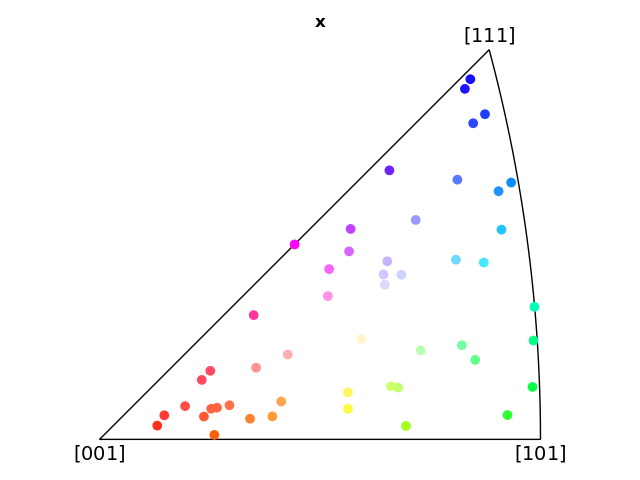

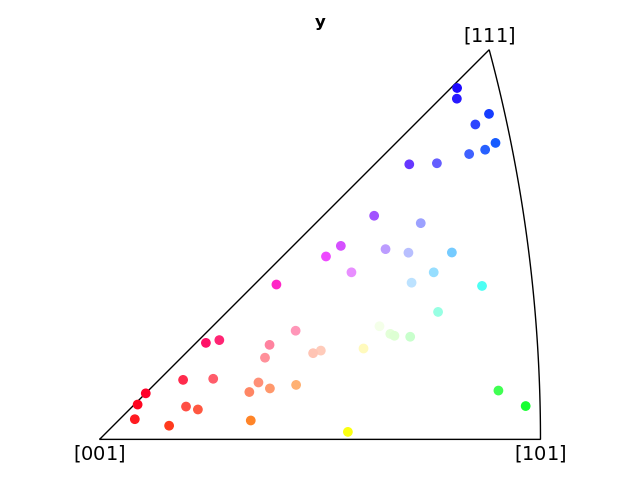

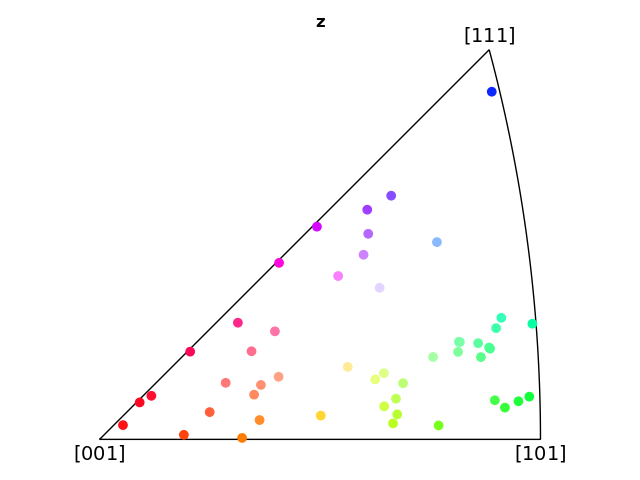

In [21]:
utils.plot_all_ipfs(grains2)

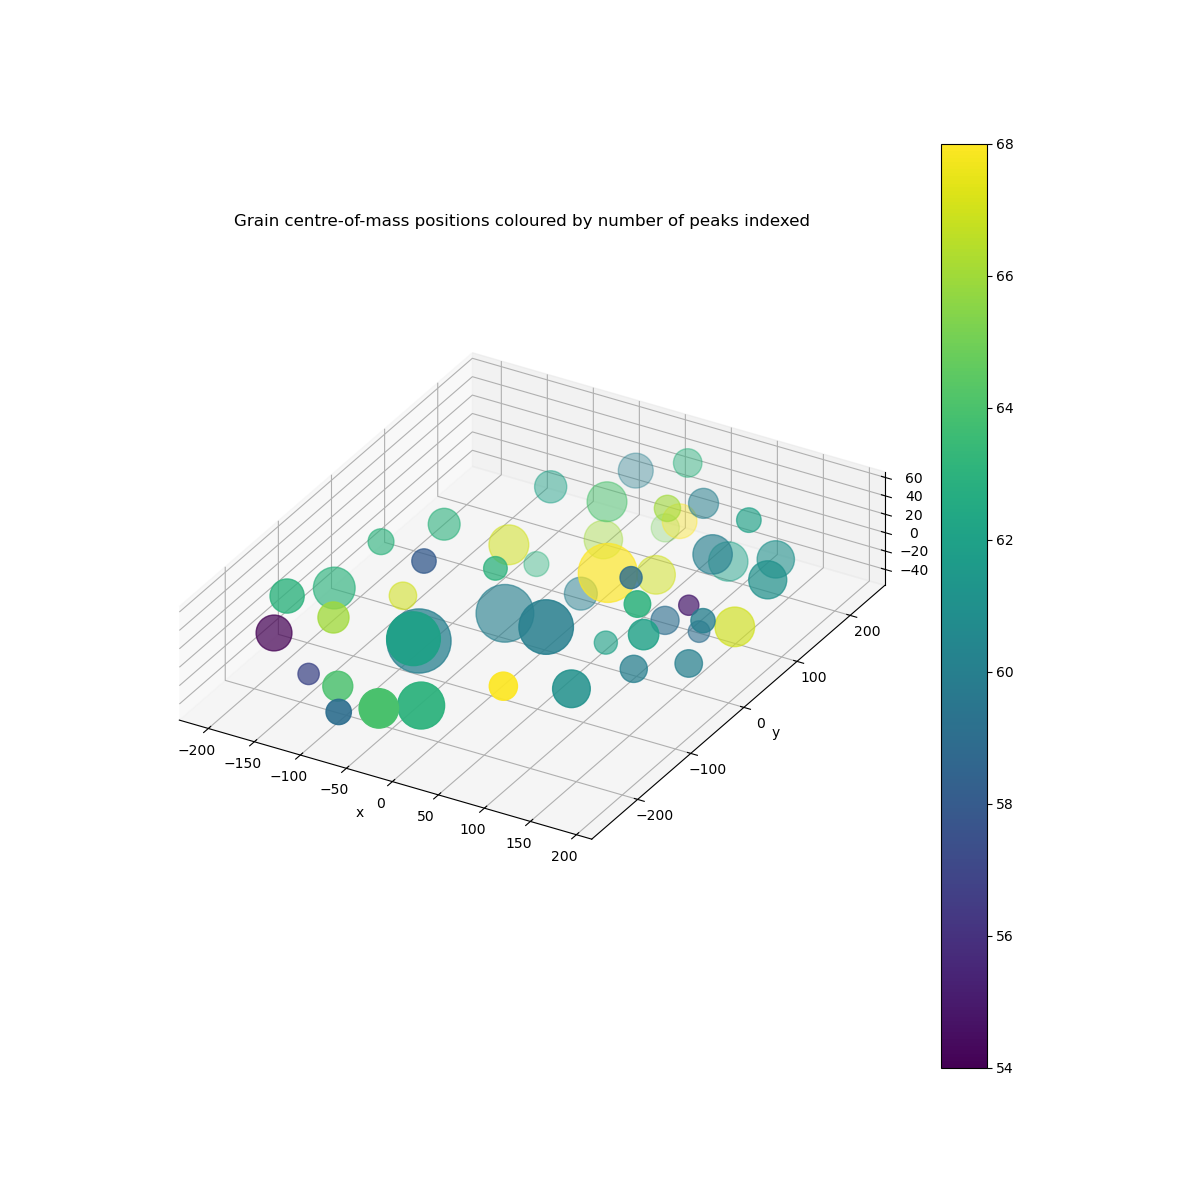

In [22]:
utils.plot_grain_positions(grains2, colour='npks', centre_plot=False, size_scaling=0.5)

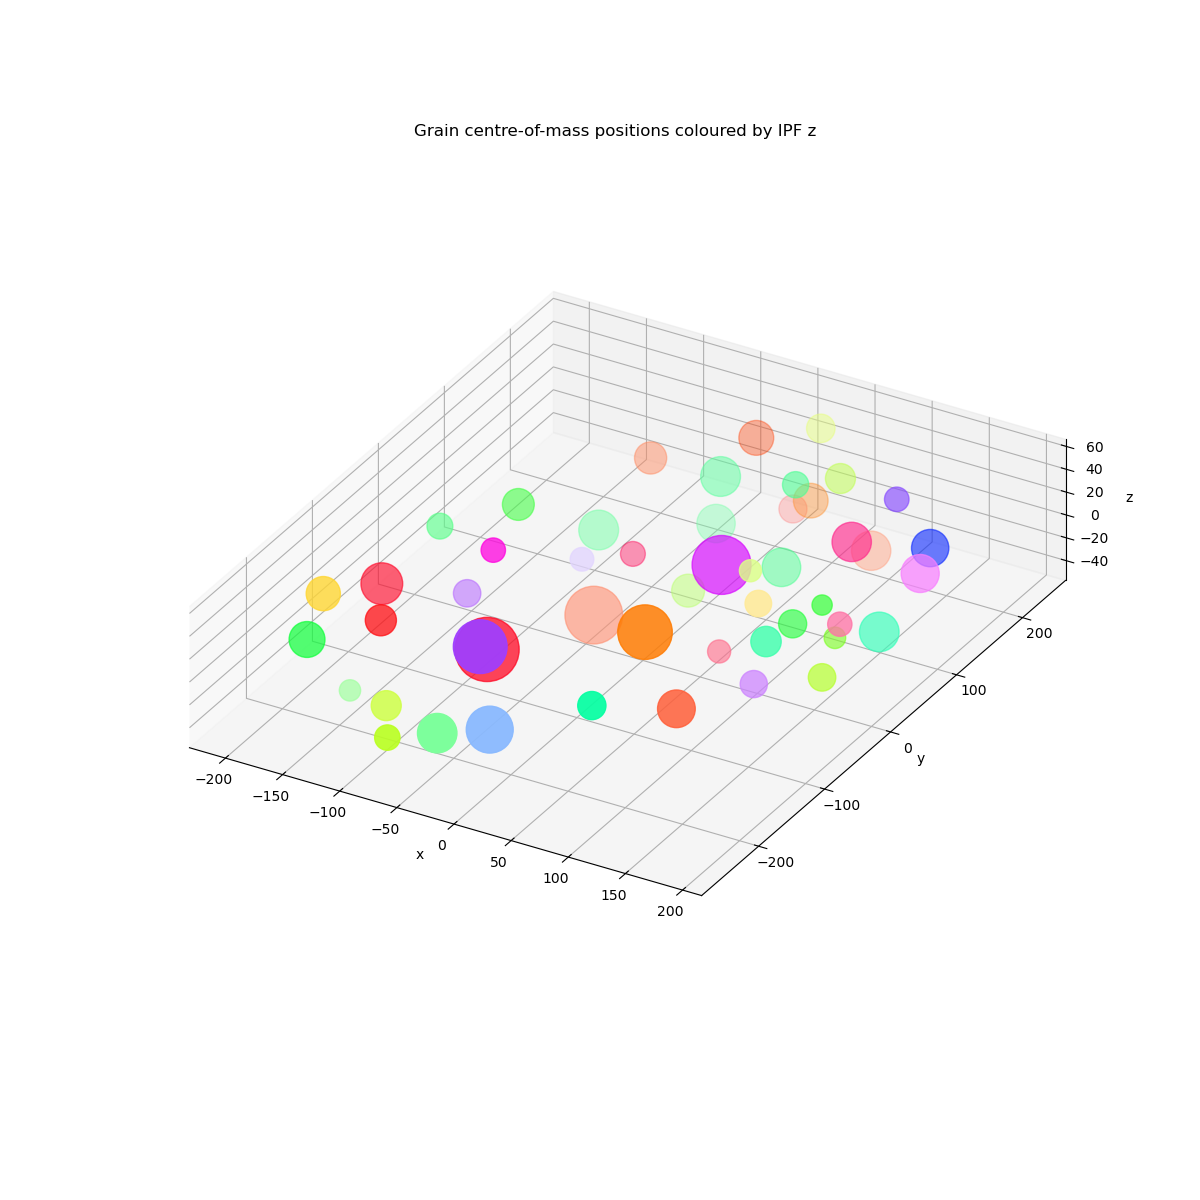

In [23]:
utils.plot_grain_positions(grains2, colour='z', centre_plot=False, size_scaling=0.5)

# Grain refinement

In [24]:
makemap_output = !makemap.py -p {oldparfile} -u {map_path} -U {new_map_path} -f {grid_peaks_path} -s {symmetry} -t {makemap_tol_seq[-1]} --omega_slop={omega_slop} --no_sort

Using 0.12500652156180614 degree slop
resetting labels


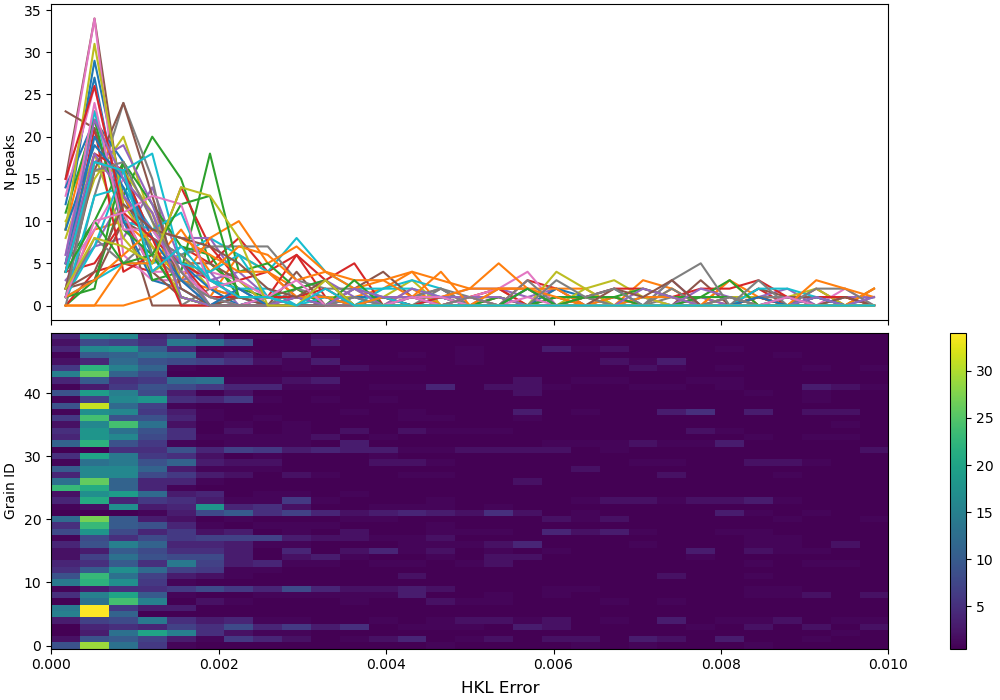

In [25]:
utils.plot_grain_histograms(new_grid_peaks_path, new_map_path, oldparfile, omega_slop, tol=makemap_tol_seq[-1])

In [26]:
grains3 = ImageD11.grain.read_grain_file(new_map_path)
grains3 = [grain for grain in grains3 if "no peaks" not in grain.intensity_info]
for g in grains3:
    g.intensity = float(g.intensity_info.split("mean = ")[1].split(" , ")[0].replace("'", ""))

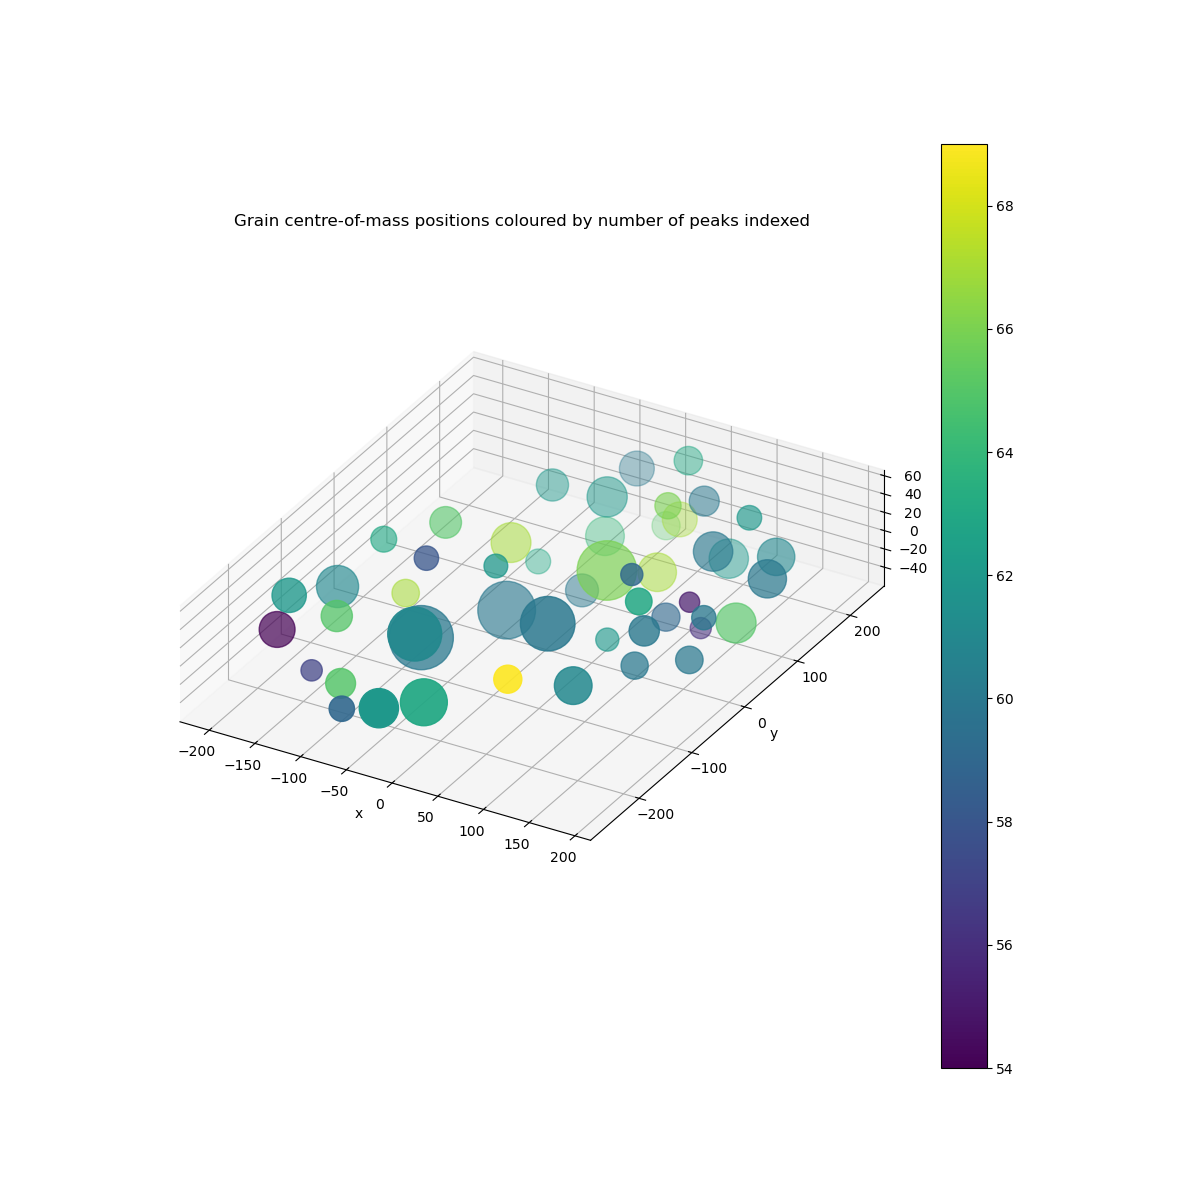

In [27]:
utils.plot_grain_positions(grains3, colour='npks', centre_plot=False, size_scaling=0.5)

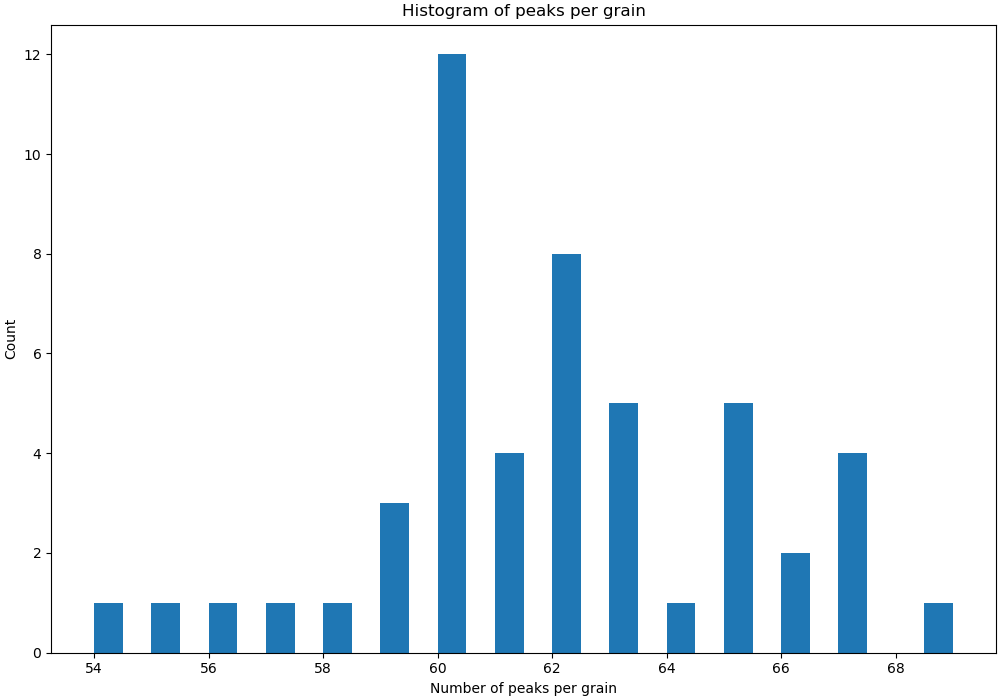

In [28]:
fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
ax.hist([float(grain.npks) for grain in grains3], bins=30)
ax.set(xlabel='Number of peaks per grain', ylabel='Count', title='Histogram of peaks per grain')
plt.show()

In [29]:
# filter out grains with fewer than absolute_minpks peaks
# most grains should have a high number of peaks
# choose absolute_minpks such that the low-peak grains are removed
grains_filtered = [grain for grain in grains3 if float(grain.npks) > absolute_minpks]

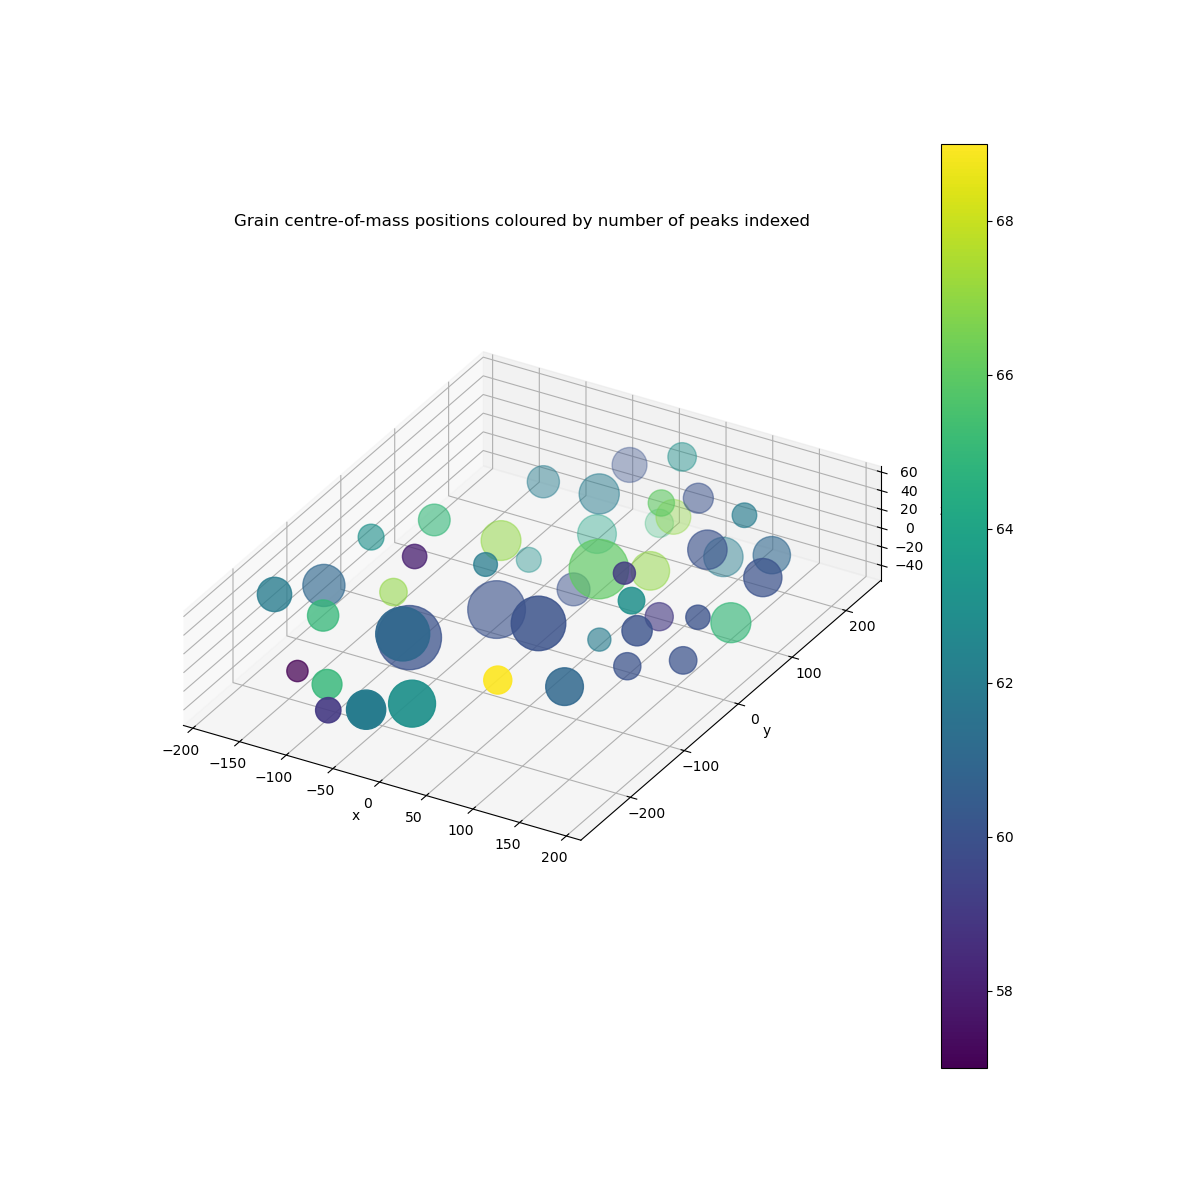

In [30]:
utils.plot_grain_positions(grains_filtered, colour='npks', centre_plot=False, size_scaling=0.5)

In [31]:
filtered_map_path = 'nice_grains.map'
new_filtered_map_path = 'nice_grains.map.new'
new_cf_3d_path = cf_3d_path + '.new'

# run makemap again against all peaks
ImageD11.grain.write_grain_file(filtered_map_path, grains_filtered)

# run makemap on filtered grains with all 3D peaks
makemap_output = !makemap.py -p {oldparfile} -u {filtered_map_path} -U {new_filtered_map_path} -f {cf_3d_path} -s {symmetry} -t {makemap_tol_seq[-1]} --omega_slop={omega_slop} --no_sort

# import makemap output columnfile with peak assignments
cf_3d = ImageD11.columnfile.columnfile(new_cf_3d_path)

# write 3D columnfile to disk
ImageD11.columnfile.colfile_to_hdf(cf_3d, ds.col3dfile, name='peaks')

# re-import filtered grains with new peak statistics
grains_final = ImageD11.grain.read_grain_file(new_filtered_map_path)
for g in grains_final:
    g.ref_unitcell = ucell

utils.get_rgbs_for_grains(grains_final)
print(f"{len(grains_final)} final grains imported")

47 final grains imported


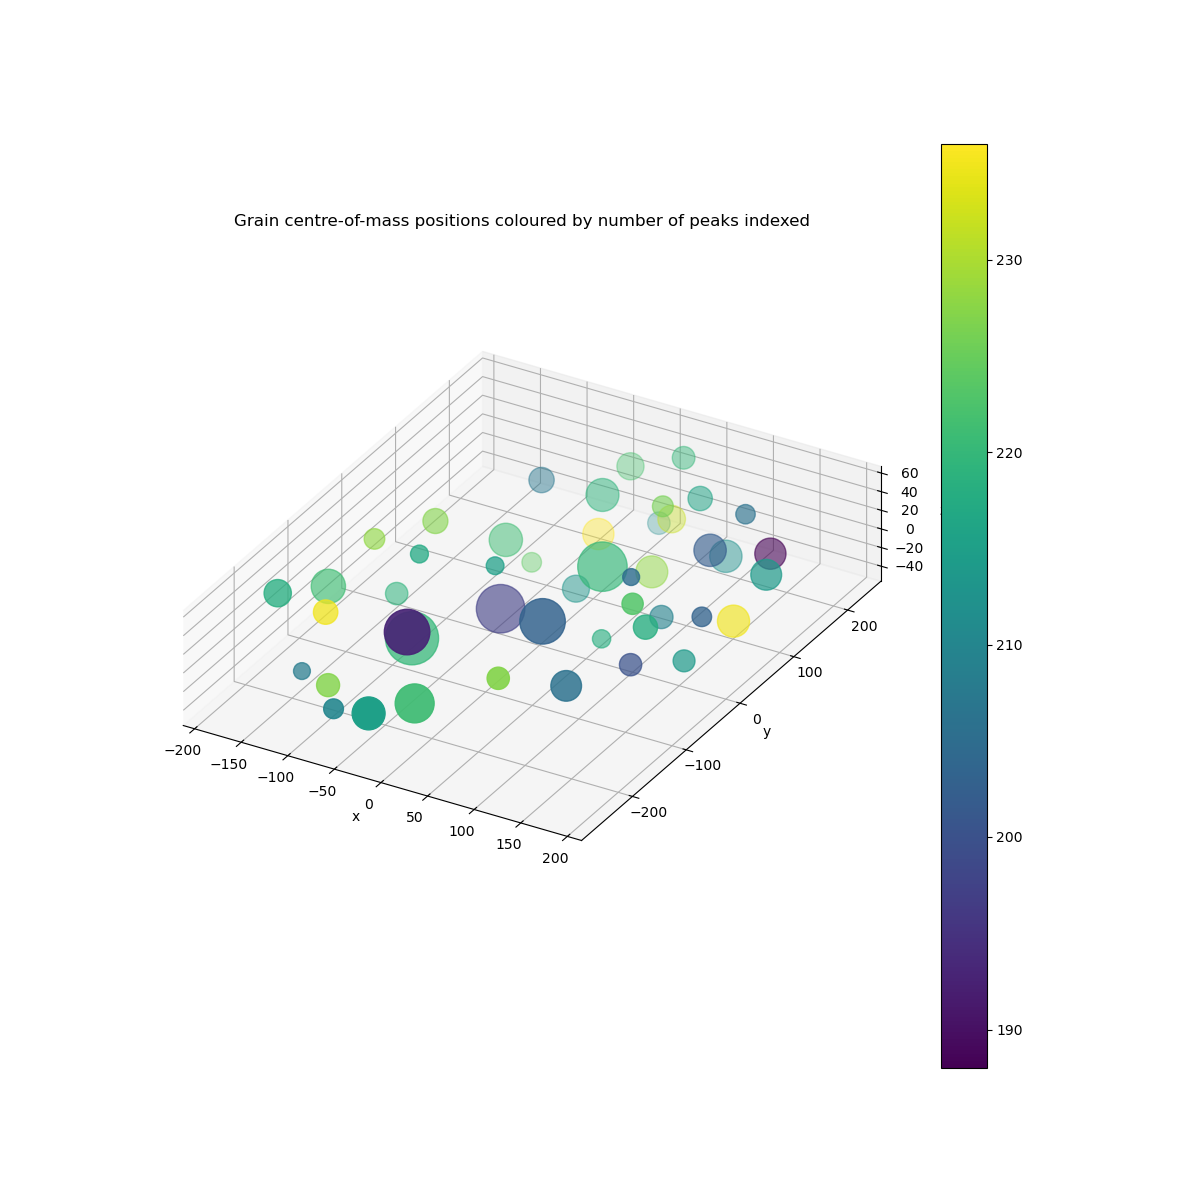

In [32]:
utils.plot_grain_positions(grains_final, colour='npks', centre_plot=False, size_scaling=0.5)

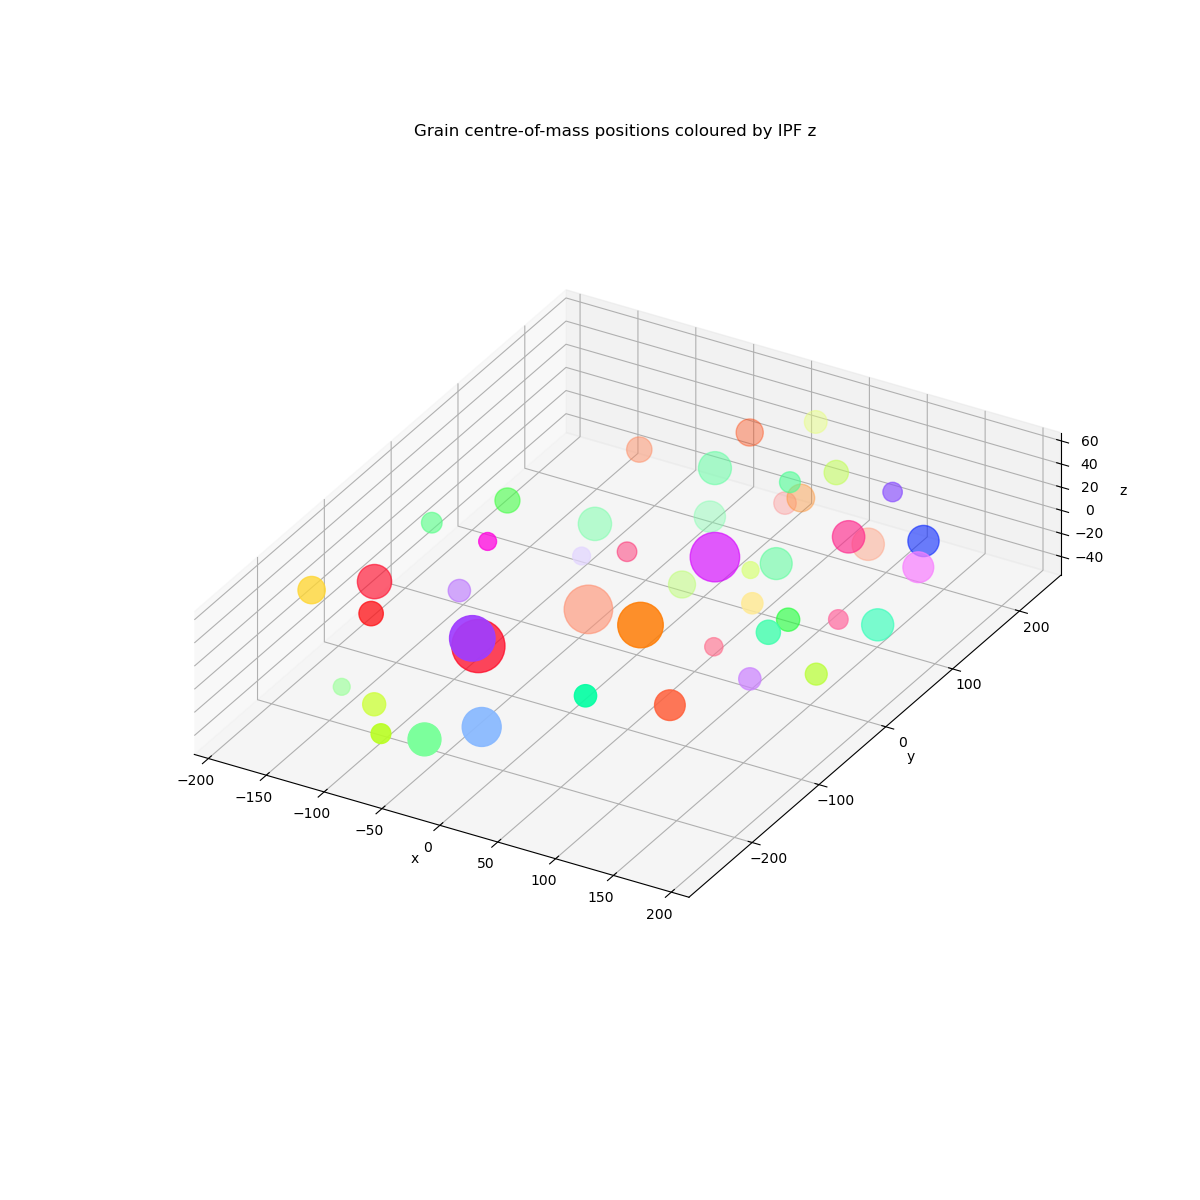

In [33]:
utils.plot_grain_positions(grains_final, colour='z', centre_plot=False, size_scaling=0.5)

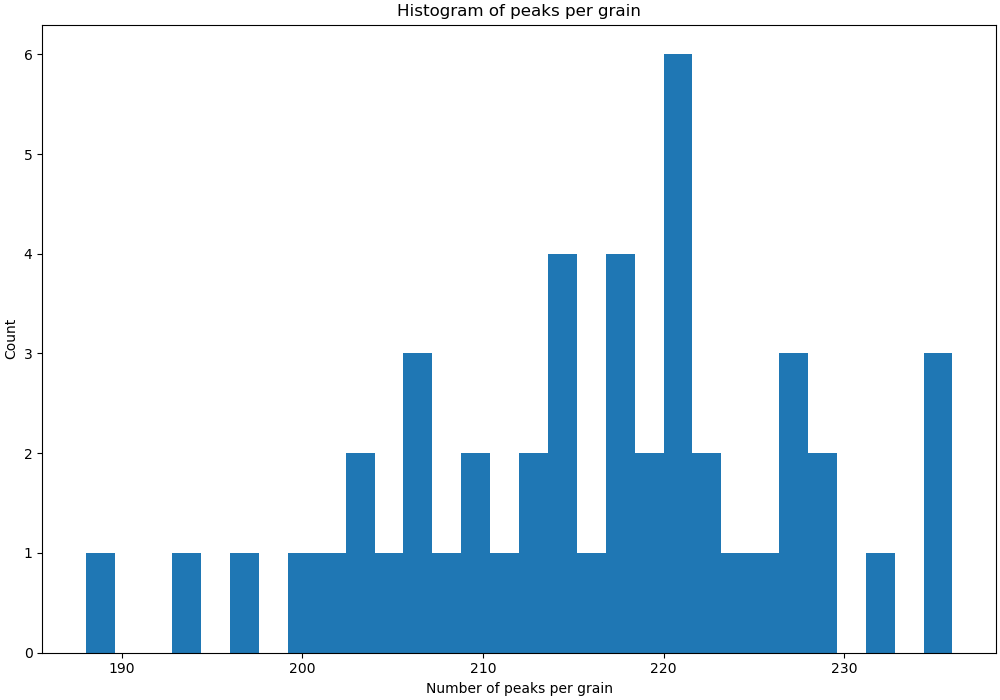

In [34]:
fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
ax.hist([float(grain.npks) for grain in grains_final], bins=30)
ax.set(xlabel='Number of peaks per grain', ylabel='Count', title='Histogram of peaks per grain')
plt.show()

Using 0.12500652156180614 degree slop
resetting labels


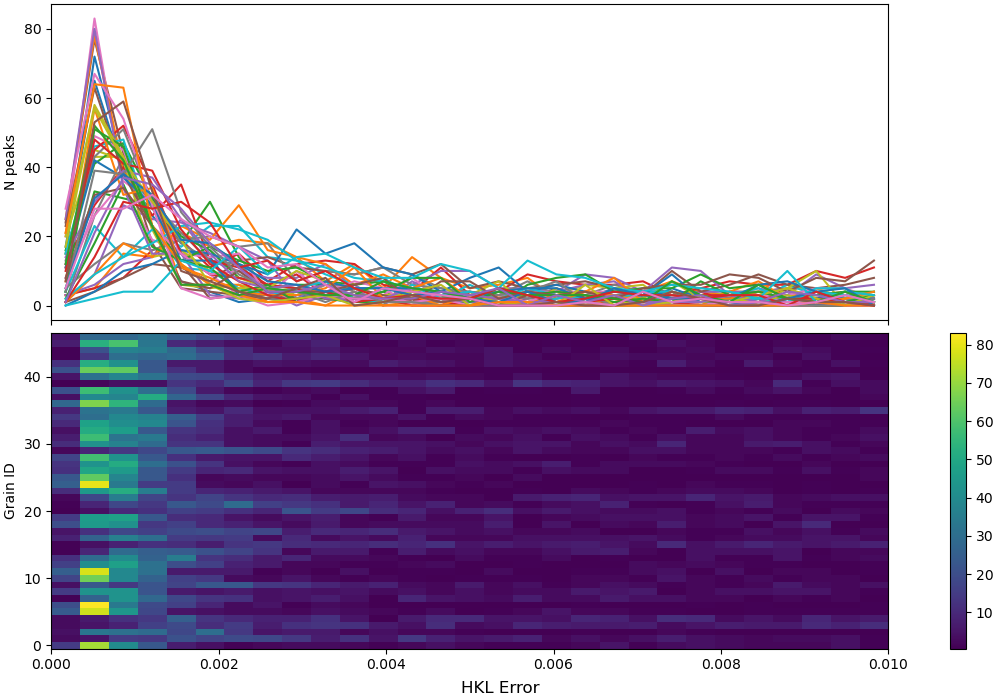

In [35]:
utils.plot_grain_histograms(new_cf_3d_path, new_filtered_map_path, oldparfile, omega_slop, tol=makemap_tol_seq[-1])

Median unit cell: [ 2.86914503  2.86972857  2.87048655 89.99220625 90.00069012 90.0101093 ]


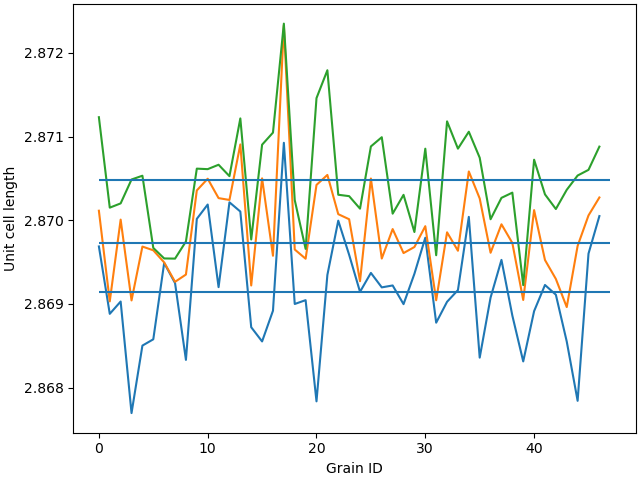

In [36]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains_final])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel="Grain ID", ylabel="Unit cell length")
plt.show()

# Export data

In [37]:
ds.save_grains_to_disk(grains_final, phase_name=phase_str)

In [38]:
ds.save()

# Deleting temporary files

In [39]:
for path in [
    cf_3d_path,
    cf_strong_allrings_path,
    grid_peaks_path,
    tmp_output_path + '.flt',
    map_path,
    new_map_path,
    new_grid_peaks_path,
    filtered_map_path,
    new_filtered_map_path,
    new_cf_3d_path,
]:
    if os.path.exists(path):
        os.remove(path)